# Examen 2 de Machine Learning

### Presentado por: 
    - Diego Osorio, código:201513417
    - Jaime Roberto Muñoz, código:200027408

## Se importan las librerías que se requieran

In [42]:
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sb
import missingno as msn
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler, PowerTransformer, StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import KernelPCA, PCA
from sklearn.metrics import accuracy_score

## Introducción

El presente informe presenta el desarrollo de un problema de clasificación de aprendizaje supervisado en el que se pretende encontrar las etiquetas o clasificar las mediciones a partir de una base dada utilizando máquinas de soporte vectorial. Para resolver el problema fueron proveídas bases de entrenamiento en los archivos xtrain.txt con sus respectivas etiquetas ytrain.txt con el propósito de realizar el entrenamiento apropiado de los modelos. Asimismo fue dada una base de evaluación o prueba xtest.txt para genear el vector de predicciones ytest.txt, utilizando el modelo óptimo entrenado previamente con la base de train-set. 


El presente informe aborda el problema de clasificación a partir mediante el siguiente procedimiento:

1. Carga de bases de datos
2. Análisis descriptivo y exploración preliminar de variables ( Análisis de balanceo de clases, correlación entre variables de la base, distribución de las variables, etc)

3. Selección de Variables ( Evaluación de poder predictivo de las variables dadas: cálculo de IV y  WoE)

4. Preprocesamiento: Estandarización de train-set, categorización, transformación de variables (Escalera de Tukey de Potencias) y definición de grupos de variables Medio-Fuerte (MF) y Medio-Fuerte con interacciones (MFI).
A partir de los resultados del cálculo de IV y WoE monotónico, se establecen 2 grupos de variables que serán utilizadas como bases para encontrar los mejores modelos.


5. Selección de modelo: Sintonización de hiper paráemtros y validación cruzada k-Fold para encontrar el mejor modelo de cada uno de los grupos de variables MF y MFI.

6. Métricas de evaluación: Evaluación de desempeño de los mejores modelos a partir del cálculo de la matriz de confusión.
Selección de métrica a maximizar: teniendo en cuenta de que se busca cuantificar la precisión (accuracy) del modelo, así como minimzar la probabilidad de error del modelo, se escoge la métrica de 'Accuracy' para maximizar

Cálculo de la confianza de la precisión (accuracy) del modelo entrenado, así como también los intervalos de confianza.

7. Generar el el vector de predicciones/etiquetas utilizando el modelo óptimo entre los 2 mejores modelos entre el grupo MF y MFI, utilizando el modelo óptimo entrenado utilizando la base de entramiento, y previamente validado utilizando validación cruzada (K-Fold=5)

A continuacion se detallan cada uno de los pasos aquí mencionados.


# 1 .Funciones auxiliares

Se definen funciones auxiliares para estandarizar, categorizar variables continuas y calcular el IV y el WoE de las variables categorizadas.   Varias de estas funciones son tomadas de del material de curso Machine Learning del profesor Fernando Lozamo.

In [2]:
# Función para estandarizar las variables continuas
def estandarizacion(df):
    return df.apply(lambda x: (x-x.mean())/x.std(), axis=0)

# Cálculo de IV #Tomada del material del curso Machine Learning Profesor Fernando Lozano.
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('El IV de esta variable es:',iv)
    print(df[feature].value_counts())
    return iv, data

# Matriz de Confusión  #Tomada del material del curso Machine Learning Profesor Fernando Lozano.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')
    
# Codificación One-Hot #Tomada del material del curso Machine Learning Profesor Fernando Lozano.
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

def convert_dummy2(df):
    pd.get_dummies(df, drop_first=True)
    return df

#Tomada del material del curso Machine Learning Profesor Fernando Lozano.
def get_category(df, col, binsnum, labels, prefijo, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = prefijo + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

## Carga de la base de datos datos

In [3]:
#Se cargan las variables descriptoras
Xdata = pd.read_csv("xtrain.txt", header=None, sep='\s+')
Xdata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,40572.0,725.331,250.71401,206.47193,1.214276,0.567264,40900.0,227.28369,0.767479,0.991980,0.969089,0.906546,0.006179,0.002574,0.821825,0.997923
1,38180.0,740.017,272.92339,178.76282,1.526735,0.755635,38709.0,220.48194,0.718669,0.986334,0.876118,0.807853,0.007148,0.001878,0.652626,0.996387
2,46827.0,808.608,300.96747,198.95893,1.512712,0.750329,47295.0,244.17614,0.781766,0.990105,0.899974,0.811304,0.006427,0.001718,0.658214,0.995688
3,72058.0,1035.943,397.71702,233.41022,1.703940,0.809677,73724.0,302.89783,0.764541,0.977402,0.843763,0.761591,0.005519,0.001145,0.580021,0.988322
4,80886.0,1136.801,391.65449,263.80113,1.484658,0.739136,82299.0,320.91627,0.719492,0.982831,0.786528,0.819386,0.004842,0.001346,0.671394,0.996790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,60453.0,978.679,404.64330,190.78109,2.120982,0.881877,61185.0,277.43675,0.679858,0.988036,0.793135,0.685633,0.006694,0.000912,0.470092,0.997058
8996,71081.0,1078.031,397.44650,228.98614,1.735679,0.817349,72466.0,300.83740,0.697693,0.980888,0.768601,0.756926,0.005591,0.001132,0.572936,0.994434
8997,38172.0,712.280,255.33277,190.54541,1.340010,0.665651,38486.0,220.45884,0.744094,0.991841,0.945482,0.863418,0.006689,0.002293,0.745490,0.998964
8998,55035.0,917.600,379.34682,185.39058,2.046203,0.872446,55591.0,264.71256,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380


In [4]:
#Se carganlas etiquetas
Ydata = pd.read_csv("ytrain.txt", header=None)
Ydata.head(10)

,0
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0
5,1.0
6,0.0
7,0.0
8,0.0
9,1.0


## Análisis exploratorio y preparación de los datos


El análisis exploratiorio tiene por objetivo saber de primera mano la distribución de las variables descriptoras y determinar el tipo de balanceo de las etiquetas dadas de los datos de entrenamiento con los que se ajustarán los modelos. Así mismo, se revisa si existen valores perdidos/no reportados (NAs), se estandarizan las variables de tal manera que tengan media = 0 y varianza = 1, y se revisa la correlación exitente entre las variables mediante la matriz de correlación de las variables en la base.  

Dado que las variables de este problema no se pueden poner en contexto, resulta complicado determinar  si dos variables que tienen una correlación alta están brindando la misma información, por lo que una de ellas sería redundante o si por el contrario a pesar de estar correlacionadas miden cosas distintas, generando entre otras posibles problemas de multicolinealidad y sobre especificación del problema.

Finalmente se hacen los histogramas de cada variable para saber como son sus distribuciones, lo que será útil al momento de tener que realizar transformación de variables.

<AxesSubplot:ylabel='0'>

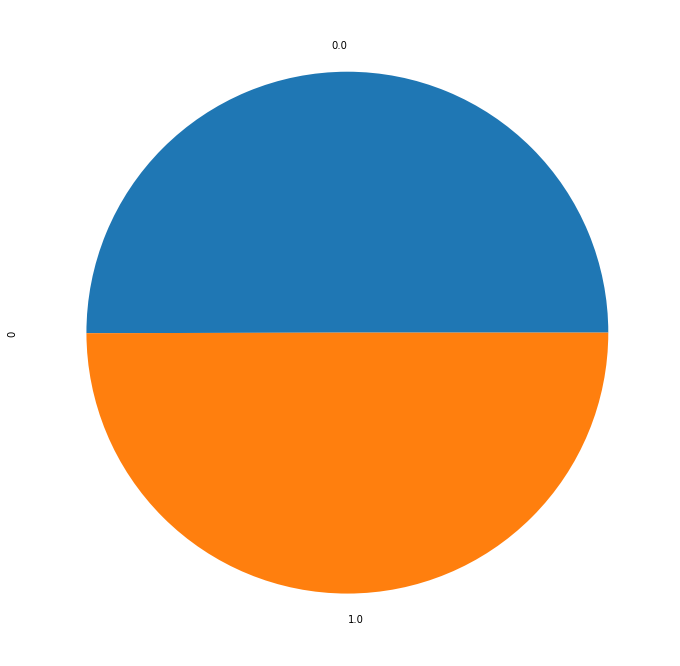

In [ ]:
#Se revisa si las clases están balanceadas
Ydata[0].value_counts().plot(kind='pie')

El gráfico anterior muestra que los datos se encuentran balanceados pues cada categoría de la etiqueta o variable y a clasificar tiene el 50% de los datos, entonces se trata de un problema de clases balanceado y no se requiere realizar dentro de la etapa de pre procesamieno alguna técnica para tratar el problema de desbalance (oversampling, undersampling, KNN, etc)

Por otro lado en la grafica siguiente no se encuentran valores perdidos/no registrados en los datos, que se ven representados en la gráfica como espacios en blanco. Como se puede observar no existen.

<AxesSubplot:>

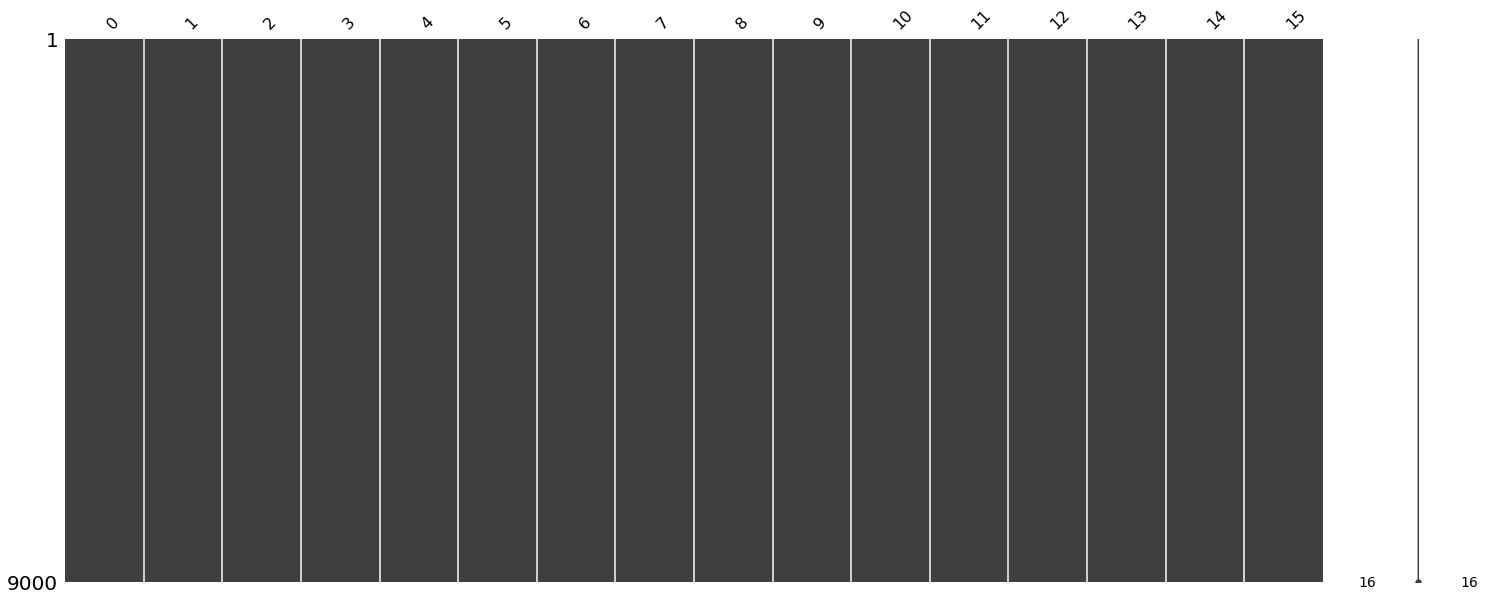

In [ ]:
msn.matrix(Xdata)

El siguiente gráfico es un mapa de calor donde se muestran las correlaciones entre las variables, las correlaciones más altas a aparecen en azul oscuro (para una correlación que tienden a 1) o blanco (para una correlación que tienden a -1). Se puede observar que las variables 0, 1,2,3,6 y 12 se encuentran muy correlacionadas junto con la 14, 13 11 y 10; también la 15 con la 10.

Desafortunadamente al no tener estas variables contexto, no podemos saber, como se dijo anteriormente si las variables altamente correlacionadas son redundantes o no.

<AxesSubplot:>

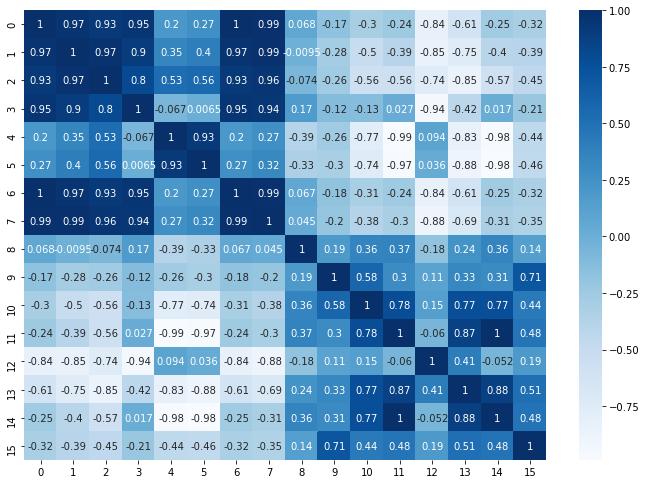

In [ ]:
correl = Xdata.corr()
rcParams['figure.figsize'] = 11.7,8.27
sb.heatmap(correl, cmap="Blues", annot=True)

Debido a las diferencia en los órdenes de magnitud entre las variables, que se evidencia disimiltud en la magnitud de valores que toman.  Adicionalmente, los limites de decisión maximizan las distancia entre puntos cercanos con etiquetas diferentes.  Dado que se usan distancias y estas se ven afectadas al no estar los datos escalados.  Por lo anterior, se procede a estandarízar las variables continuas, centrando los datos y luego dividiendo cada variable descriptora por su desviación estándar.

In [ ]:
XdataEst = estandarizacion(Xdata)
XdataEst.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.549056,-0.774288,-0.962352,-0.070251,-1.463149,-1.856969,-0.555827,-0.597450,0.358633,1.039852,1.672519,1.660089,-0.142959,1.513182,1.717682,0.706257
1,-0.626380,-0.707437,-0.710874,-0.662114,-0.291320,0.018311,-0.625590,-0.708909,-0.595637,-0.088408,0.178511,0.183947,0.714476,0.396986,0.142015,0.380515
2,-0.346858,-0.395211,-0.393330,-0.230728,-0.343911,-0.034514,-0.352208,-0.320637,0.637957,0.665042,0.561877,0.235567,0.076289,0.139872,0.194054,0.232319
3,0.468754,0.639619,0.702171,0.505147,0.373264,0.556315,0.489303,0.641623,0.301199,-1.873106,-0.341414,-0.507984,-0.727132,-0.777332,-0.534120,-1.330355
4,0.754127,1.098725,0.633525,1.154292,-0.449122,-0.145939,0.762335,0.936887,-0.579545,-0.788368,-1.261142,0.356450,-1.326585,-0.455232,0.316787,0.466011
5,0.847451,1.090258,1.263857,0.698472,0.902008,0.861776,0.880941,1.029914,0.686271,-2.586312,-0.767084,-0.978898,-0.886170,-1.113085,-0.971489,-2.364180
6,-0.505869,-0.517409,-0.478836,-0.580709,0.010107,0.289040,-0.505519,-0.536625,-0.676044,-0.048263,-0.053156,-0.124015,0.584466,0.045846,-0.163840,0.310671
7,-0.584970,-0.717383,-0.601441,-0.668165,-0.079150,0.214111,-0.589101,-0.648798,0.561655,0.666940,0.737187,-0.035144,0.725861,0.189564,-0.076387,0.335683
8,0.151250,0.444083,0.874348,-0.350207,1.991597,1.292013,0.142752,0.290955,1.615478,0.721716,-1.154468,-1.702592,0.259989,-1.196369,-1.607642,-0.456721
9,1.208434,1.309487,1.447092,1.133075,0.597255,0.696084,1.198103,1.375459,-1.579100,0.466869,-0.203524,-0.679701,-1.291160,-1.085040,-0.695744,-0.474959


Se agraga una nueva columna al conjunto de datos que contiene las etiquetas (ytrain)

In [ ]:
df=XdataEst
df['Etiqueta']=Ydata[0]
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Etiqueta
0,-0.549056,-0.774288,-0.962352,-0.070251,-1.463149,-1.856969,-0.555827,-0.597450,0.358633,1.039852,1.672519,1.660089,-0.142959,1.513182,1.717682,0.706257,1.0
1,-0.626380,-0.707437,-0.710874,-0.662114,-0.291320,0.018311,-0.625590,-0.708909,-0.595637,-0.088408,0.178511,0.183947,0.714476,0.396986,0.142015,0.380515,0.0
2,-0.346858,-0.395211,-0.393330,-0.230728,-0.343911,-0.034514,-0.352208,-0.320637,0.637957,0.665042,0.561877,0.235567,0.076289,0.139872,0.194054,0.232319,0.0
3,0.468754,0.639619,0.702171,0.505147,0.373264,0.556315,0.489303,0.641623,0.301199,-1.873106,-0.341414,-0.507984,-0.727132,-0.777332,-0.534120,-1.330355,1.0
4,0.754127,1.098725,0.633525,1.154292,-0.449122,-0.145939,0.762335,0.936887,-0.579545,-0.788368,-1.261142,0.356450,-1.326585,-0.455232,0.316787,0.466011,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.093613,0.378953,0.780598,-0.405406,1.937320,1.275080,0.090056,0.224398,-1.354410,0.251748,-1.154973,-1.644089,0.311964,-1.150740,-1.557836,0.522777,0.0
8996,0.437172,0.831203,0.699108,0.410649,0.492297,0.632684,0.449248,0.607859,-1.005722,-1.176671,-1.549225,-0.577769,-0.663361,-0.798523,-0.600100,-0.033861,1.0
8997,-0.626638,-0.833696,-0.910054,-0.410440,-0.991603,-0.877504,-0.632690,-0.709287,-0.098565,1.012028,1.293162,1.015027,0.307970,1.062198,1.006812,0.927206,1.0
8998,-0.081528,0.100921,0.494164,-0.520546,1.656873,1.181195,-0.088059,0.015889,0.988480,0.643806,-0.701157,-1.461935,0.488353,-0.997309,-1.400935,0.379009,0.0


Se renombran las variables para facilitar su manejo.

In [ ]:
df.rename(columns={0:'Var_0',1:'Var_1', 2:'Var_2',3:'Var_3',4:'Var_4',5:'Var_5',6:'Var_6',7:'Var_7',8:'Var_8',
                   9:'Var_9',10:'Var_10',11:'Var_11',12:'Var_12',13:'Var_13',14:'Var_14',15:'Var_15'},inplace=True)
df.head(10)

,Var_0,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15,Etiqueta
0,-0.549056,-0.774288,-0.962352,-0.070251,-1.463149,-1.856969,-0.555827,-0.597450,0.358633,1.039852,1.672519,1.660089,-0.142959,1.513182,1.717682,0.706257,1.0
1,-0.626380,-0.707437,-0.710874,-0.662114,-0.291320,0.018311,-0.625590,-0.708909,-0.595637,-0.088408,0.178511,0.183947,0.714476,0.396986,0.142015,0.380515,0.0
2,-0.346858,-0.395211,-0.393330,-0.230728,-0.343911,-0.034514,-0.352208,-0.320637,0.637957,0.665042,0.561877,0.235567,0.076289,0.139872,0.194054,0.232319,0.0
3,0.468754,0.639619,0.702171,0.505147,0.373264,0.556315,0.489303,0.641623,0.301199,-1.873106,-0.341414,-0.507984,-0.727132,-0.777332,-0.534120,-1.330355,1.0
4,0.754127,1.098725,0.633525,1.154292,-0.449122,-0.145939,0.762335,0.936887,-0.579545,-0.788368,-1.261142,0.356450,-1.326585,-0.455232,0.316787,0.466011,1.0
5,0.847451,1.090258,1.263857,0.698472,0.902008,0.861776,0.880941,1.029914,0.686271,-2.586312,-0.767084,-0.978898,-0.886170,-1.113085,-0.971489,-2.364180,1.0
6,-0.505869,-0.517409,-0.478836,-0.580709,0.010107,0.289040,-0.505519,-0.536625,-0.676044,-0.048263,-0.053156,-0.124015,0.584466,0.045846,-0.163840,0.310671,0.0
7,-0.584970,-0.717383,-0.601441,-0.668165,-0.079150,0.214111,-0.589101,-0.648798,0.561655,0.666940,0.737187,-0.035144,0.725861,0.189564,-0.076387,0.335683,0.0
8,0.151250,0.444083,0.874348,-0.350207,1.991597,1.292013,0.142752,0.290955,1.615478,0.721716,-1.154468,-1.702592,0.259989,-1.196369,-1.607642,-0.456721,0.0
9,1.208434,1.309487,1.447092,1.133075,0.597255,0.696084,1.198103,1.375459,-1.579100,0.466869,-0.203524,-0.679701,-1.291160,-1.085040,-0.695744,-0.474959,1.0


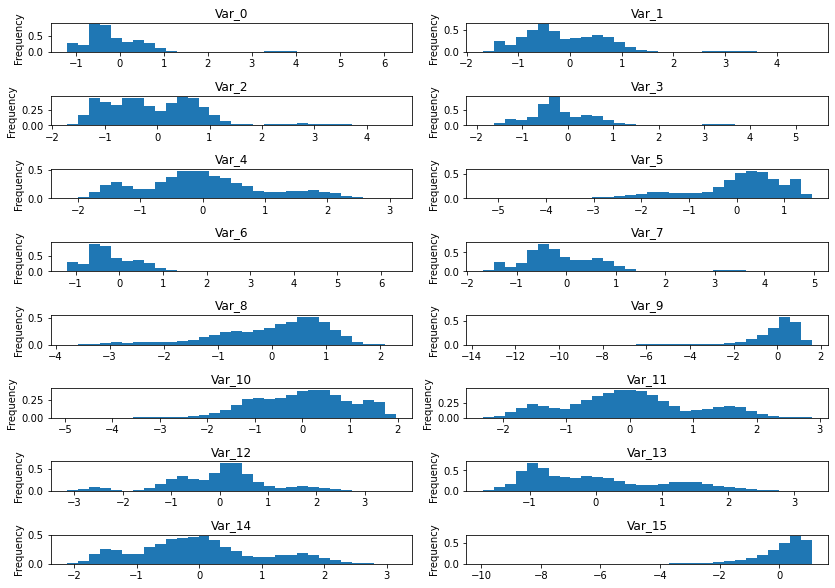

In [ ]:
namelist = ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15']

nrow=8
ncol=2
fig, axes = plt.subplots(nrow, ncol)

# Para generar histogramas de cada variable##
plt.rcParams["figure.figsize"] = (12,12)
contador=0
for f in range(nrow):
    for c in range(ncol):
        df[namelist[contador]].plot(kind='hist', bins= 30, density=True, ax=axes[f,c])
        axes[f,c].title.set_text(namelist[contador])
        contador=contador+1
#Espaciando
fig.tight_layout()
plt.show()
    

Los histogramas permiten observar el comportamiento de las variables, y esto permite de ser necesario encontrar las transformaciones más adecuadas en caso de requerirse. 

Los histogramas en este caso nos permiten observar lo siguiente:
   - Var_0: Muestra una distribución sesgada por derecha.
   - Var_1: Muestra bimodal con sesgo postivo.
   - Var_2: Distribución multimodal con sesgo positivo.
   - Var_3: Distribución multimodal con sesgo positivo.
   - Var_4: Distribución muestra tres modas y es ligeramente sesgada por derecha.
   - Var_5: Distribución con sesgo negativo.
   - Var 6: Distribución sesgada por derecha.
   - Var 7: Distribución con sesgo Positivo.
   - Var 8: Distribución con sesgo negativo y dos modas.
   - Var 9: Distribución con sesgo negativo.
   - Var 10: Distribución con sesgo negativo y dos modas.
   - Var 11: Distribución más o menos simétrica con tres modas.
   - Var 12: Distribución más o menos simétrica con tres modas.
   - Var 13: Distribución con sesgo postivo multimodal.
   - Var 14: Distribución más o menos simétrica multimodal.
   - var 15: Distribución con sesgo negativo.
   
 A continuacion categorizamos las todas variables originales en 3 grupos, y de acuerdo con los resultados aumentaremos o disminuiremos la cantidad de categorías, buscando como categorizar de menor manera las variables continuas y al mismo tiempo mejorar su poder predictivo, con el fin de ayudar a que el modelo sea mejor clasificando.  A cada intento le dimos un prefijo diferente para poder diferenciarlos posteriormente.  
 
Es importante mencionar que a las variables obtenidas se les coloca el prefijo gp.

## Selección de variables con IV y WoE


Teniendo en cuenta que todas las variables son continuas y ya teniéndolas estandarizadas, vamos a revisar su aporte al problema de clasificación cuantificando su poder predictivo calculando el IV (information Value) y Weight of evidence (WoE). 

WoE e IV pueden ser usados para entender el poder predictivo de una variable con la desventaja que es una análisis individual por variable, es decir que no tiene en cuenta interacciones entre las variables.  A continuación se muestra como se definen estos valores.


$WoE = \ln{\frac{Porcentaje de buenos en la clase}{Porcentaje de malos en la clase}}$

Donde el cálculo de IV se obtiene de la siguiente manera:

$IV = WoE*\frac{Proporcion de buenso en la clase}{Proporción de malos en la clase}$


Dependiento el valor que tomen se determina su poder predictivo con base el $IV$ y si la variable se encuentra bien categorizda con el WoE.  Si una variable está bien categorizada, entonces el cálculo de WoE para cada categiría decrece o crece monotónicamente entre las categorías adyacentes.


Por otro lado, los valores de referencia de $IV$ que se toman en cuenta para determinar el poder predictivo de la variable son:

- Menor a 0.02 se considera un predictor inservible
- De 0.02 a 0.1 se considera un predictor debil
- De 0.1 a 0.3 Se considera un predictor medio
. De 0.3 a 0.5 Se considera un predictor fuerte
- Mayor a 0.5 La variable se considera sospechosa


Buscamos variables que cuyo IV este en el rango $0.1 \leq IV \leq 0.5$ que pues son las que tienen un poder predictivo medio a fuerte y son recomendadas por algunos autores para tener en cuenta a la hora de construir bases de entrenamiento en el problema de 
predicción.

La utilización del cálculo de IV y WoE lo desarrolla en detalle Chakraborty[2]




En primera instancia categorizamos todas las variables en tres categorías Alta, Media y Baja y se hace el análisis del WoE y el IV.  A las variables que se generan de este primer análisis se les antepone el prefijo gp.

( A manera de expliración, aquellas variables  que están por debajo de este rango las analizaremos para ver si con una transformación y/o creando una interaccion pueden mejorar)

In [ ]:
#Se crea la tabla IV
ivtable=pd.DataFrame(df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable.head()

,variable,IV
16,Etiqueta,None


In [ ]:
# Se categorizan las variables y se revisa si la categorización es adecuada y su poder de predicción de acuerdo con lo ya explicado.
for var in namelist:
    print('Variable:',var)
    print('')
    df = get_category(df, var, 3, ["Bajo", "Medio", "Alto"], 'gp', qcut = True)
    iv, data = calc_iv(df,'gp_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gp_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: Var_0

El IV de esta variable es: 1.6995068037058123
Alto     3000
Bajo     3000
Medio    3000
Name: gp_Var_0, dtype: int64

   Variable  Value   All  Good   Bad     Share  Bad Rate  Distribution Good  \
0  gp_Var_0   Alto  3000   342  2658  0.333333  0.886000           0.075949   
1  gp_Var_0   Bajo  3000  1721  1279  0.333333  0.426333           0.382190   
2  gp_Var_0  Medio  3000  2440   560  0.333333  0.186667           0.541861   

   Distribution Bad       WoE        IV  
0          0.591061 -2.051852  1.056932  
1          0.284412  0.295494  0.028893  
2          0.124527  1.470483  0.613682  

Variable: Var_1

El IV de esta variable es: 1.5674273530955616
Alto     3000
Bajo     3000
Medio    3000
Name: gp_Var_1, dtype: int64

   Variable  Value   All  Good   Bad     Share  Bad Rate  Distribution Good  \
0  gp_Var_1   Alto  3000   426  2574  0.333333  0.858000           0.094604   
1  gp_Var_1   Bajo  3000  1583  1417  0.333333  0.472333           0.351543   
2  gp_V

Analizando el IV y WoE podemos decir:

- Las variables gp_Var_0, gp_Var_1, gp_Var_2, gp_Var_3,gp_Var_6, gp_Var_7, gp_Var_12; tienen un IV mayor a 0.5 lo que hace sospechosas, demasiado bueno para ser cierto.  El WoE de estas variables tiene el comportamiento monotónico deseado, excepto para la variable gp_Var_12.

- Las variables: gp_Var_4, gp_Var_5, gp_Var_8, gp_Var_11; Hay que revisar la cantidad de categorías pues el WoE no es monotónico, es decir a medida que se deciende en el orden de las categorias no tiene una tendencia de descenso o ascenso, sino que aumenta y luego baja visceversa.
- Las variables: gp_Var_9,  gp_Var_14, gp_Var_15; Tienen un IV que muestra un poder predictivo entre medio y fuerte.
- Las variables: gp_Var_13 y gp_Var_10  tienen un poder predictivo debil o no tienen y un WoE monotónico que se puede observar al revisar su comportamiento en las categorías.

Con base en lo anterior se procede a cambiar la agrupación en el número de categorías de las variables sospechosas al momento de categorizar IV > 0.5, exploraremos otras categorizaciones para aquellas cuyo WoE no fue monotónico y la creación de unas nuevas variables de interacción, por ejemplo entre Var_13 y Var_10 que por si solas no tiene un poder predictivo fuerte.  Agregamos a la lista de variables una interacción, Var_1310, que definieremos más adelante.
 

In [ ]:
#Se crea la tabla IV
ivtable=pd.DataFrame(df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15', 'Var_1310']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable.head()

,variable,IV
16,Etiqueta,None
17,gp_Var_0,None
18,gp_Var_1,None
19,gp_Var_2,None
20,gp_Var_3,None


Para transformar las variables Var_13 y Var_10, se utilizó la escalera de Tukey que utiliza transformaciones de potencias.  Esta metodología es desarrollada por el autor Tukey [3]
  

La escalera es la que se muestra a continuación:

<img src="Image.png" width=500 height=2000>
Tomada de: https://onlinestatbook.com/2/transformations/tukey.html

Hacia la izquierda se dice que se baja en la escalera y hacia la derecha se sube.  La variable sin transformar es $X^1$.

Si la varible tiene una distribucion con sesgo negativo se sube y si tiene sesgo positivo se baja hasta que se llegue a una simetrización que se considere suficiente de la distribución.

En nuestro caos la variable Var_13 tiene sesgo positivo y se baja hasta que $\lambda = -1$  y para Var_10 que tiene sesgo negativo se sube hasta que $\lambda = 2$.

A continuación generamos variable Var_1310 que resulta de la interacción de las variables Var_13 y Var_10 transformadas como se acaba de explicar.  Luego exploramos como categorizar Var_1310 en 3 categorías y le anteponemos a la variable categórica creada el prefijo gpI1.

In [ ]:
#Primero creamos la variable de la interacción entre Var_13 y Var10  que llamamos Var_1310

# La trasnformacion que se muestra a cotinuación se basa en la Escalera de Tukey.  Al tener Var_13 un sesgo positivo se baja
# en la escalera y se hace la transformación 1/Var_13 y al tener Var_10 un sesgo negativo se sube en la escalera y se transforma
# elevando la variable a cuadrado.

df['Var_1310'] = 1/df['Var_13']*(df['Var_10']*df['Var_10'])

#Ahora exploramos la categorización de esta nueva variable

df = get_category(df, 'Var_1310', 3, ["Bajo", "Medio", "Alto"], 'gpI1', qcut = True)
iv, data = calc_iv(df,'gpI1_Var_1310','Etiqueta')
ivtable.loc[ivtable['variable']== 'gpI1_'+var,'IV']=iv
print('')
print(data)
print('')

El IV de esta variable es: 0.12365258332422537
Alto     3000
Bajo     3000
Medio    3000
Name: gpI1_Var_1310, dtype: int64

        Variable  Value   All  Good   Bad     Share  Bad Rate  \
0  gpI1_Var_1310   Alto  3000  1391  1609  0.333333  0.536333   
1  gpI1_Var_1310   Bajo  3000  1862  1138  0.333333  0.379333   
2  gpI1_Var_1310  Medio  3000  1250  1750  0.333333  0.583333   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.308905          0.357794 -0.146923  0.007183  
1           0.413502          0.253058  0.491046  0.078786  
2           0.277593          0.389148 -0.337806  0.037684  



La variable categórica creada es gpI1_Var1310, observamos que el WoE obtenido no se comporta de manera monotónica, por lo anterior aumentamos las categorías, lo que también ayudará a aumentar el poder productivo de esta nueva variable de interacción. Hacemos de nuevo la categorización y le ponemos el prefijo a gpI2 a la nueva variable.

In [ ]:
df = get_category(df, 'Var_1310', 4, ["Muy bajo", "Bajo", "Medio", "Alto"], 'gpI2', qcut = True)
iv, data = calc_iv(df,'gpI2_Var_1310','Etiqueta')
ivtable.loc[ivtable['variable']== 'gpI2_'+var,'IV']=iv
print('')
print(data)
print('')

El IV de esta variable es: 0.22072824101163868
Muy bajo    2250
Alto        2250
Bajo        2250
Medio       2250
Name: gpI2_Var_1310, dtype: int64

        Variable     Value   All  Good   Bad  Share  Bad Rate  \
0  gpI2_Var_1310      Alto  2250   861  1389   0.25  0.617333   
1  gpI2_Var_1310      Bajo  2250   870  1380   0.25  0.613333   
2  gpI2_Var_1310     Medio  2250  1347   903   0.25  0.401333   
3  gpI2_Var_1310  Muy bajo  2250  1425   825   0.25  0.366667   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.191206          0.308873 -0.479578  0.056430  
1           0.193205          0.306871 -0.462679  0.052591  
2           0.299134          0.200801  0.398579  0.039194  
3           0.316456          0.183456  0.545210  0.072513  



En el resultado anterior, se puede observar que al aumentar a 4 categorías mejoro el IV a 0.22 y WoE crece monotónicamente por lo tanto usaremos gpI2_Var1310.

Dado que utilizaremos en algunos de nuestros modelos la variable de interacción, también analizaremos como se comportan las variables individuales Var_13 y Var_10 transformadas, con el objetivo de mantener el orden jerárquico, es decir que si está la interacción en el modelo incluir también las variables que interctuan individualmente. A las variables Transformadas y categorizadas les ponemos el prefijo gpT

In [ ]:
# Se crean las variables que interactuan haciendo las mismas transforaciones utilizadas para generar la interacción
df['Var_13T'] = 1/df['Var_13']
df['Var_10T'] = df['Var_10']*df['Var_10']

#Categorizamos y calculamos la IV para Var_13T
df = get_category(df, 'Var_13T', 3, ["Bajo", "Medio", "Alto"], 'gpT', qcut = True)
iv, data = calc_iv(df,'gpT_Var_13T','Etiqueta')
ivtable.loc[ivtable['variable']== 'gpT_'+var,'IV']=iv
print('')
print(data)
print('')

df = get_category(df, 'Var_10T', 3, ["Bajo", "Medio", "Alto"], 'gpT', qcut = True)
iv, data = calc_iv(df,'gpT_Var_10T','Etiqueta')
ivtable.loc[ivtable['variable']== 'gpT_'+var,'IV']=iv
print('')
print(data)
print('')


El IV de esta variable es: 0.15295834749971113
Bajo     3001
Alto     3000
Medio    2999
Name: gpT_Var_13T, dtype: int64

      Variable  Value   All  Good   Bad     Share  Bad Rate  \
0  gpT_Var_13T   Alto  3000  1904  1096  0.333333  0.365333   
1  gpT_Var_13T   Bajo  3001  1369  1632  0.333444  0.543819   
2  gpT_Var_13T  Medio  2999  1230  1769  0.333222  0.589863   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.422829          0.243718  0.550956  0.098682  
1           0.304020          0.362909 -0.177059  0.010427  
2           0.273151          0.393373 -0.364734  0.043849  

El IV de esta variable es: 0.16992275875633533
Alto     3000
Bajo     3000
Medio    3000
Name: gpT_Var_10T, dtype: int64

      Variable  Value   All  Good   Bad     Share  Bad Rate  \
0  gpT_Var_10T   Alto  3000  1121  1879  0.333333  0.626333   
1  gpT_Var_10T   Bajo  3000  1512  1488  0.333333  0.496000   
2  gpT_Var_10T  Medio  3000  1870  1130  0.333333  0.376667   

   Di

Las dos variables transformadas tienen un WoE Monotónico y un IV entre 0.1 y 0.3 que indica un poder predictivo medio.

In [ ]:
#Se crea la tabla IV actualizada con la variable de interacción y las dos variables transformadas.
ivtable=pd.DataFrame(df.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15', 'Var_1310','Var_10T', 'Var_13T']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable.head()

,variable,IV
16,Etiqueta,None
17,gp_Var_0,None
18,gp_Var_1,None
19,gp_Var_2,None
20,gp_Var_3,None


A continuación, revisamos las variables que después de hacer una primera categorización, su WoE no era monotónico. Estas variables son: Var_4, Var_5, Var_8 y Var_11 y les ponemos el prefijo gp2

In [ ]:
namelist2= ['Var_4','Var_5','Var_8','Var_11']
for var in namelist2:
    print('Variable:',var)
    print('')
    df = get_category(df, var, 4, ["Muy Bajo", "Medio", "Alto","Muy alto"], 'gp2', qcut = True)
    iv, data = calc_iv(df,'gp2_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gp2_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: Var_4

El IV de esta variable es: 0.8428038821070075
Muy alto    2250
Alto        2250
Medio       2250
Muy Bajo    2250
Name: gp2_Var_4, dtype: int64

    Variable     Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp2_Var_4      Alto  2250   971  1279   0.25  0.568444           0.215634   
1  gp2_Var_4     Medio  2250  1528   722   0.25  0.320889           0.339329   
2  gp2_Var_4  Muy Bajo  2250   399  1851   0.25  0.822667           0.088608   
3  gp2_Var_4  Muy alto  2250  1605   645   0.25  0.286667           0.356429   

   Distribution Bad       WoE        IV  
0          0.284412 -0.276841  0.019040  
1          0.160551  0.748356  0.133790  
2          0.411608 -1.535853  0.496081  
3          0.143429  0.910295  0.193893  

Variable: Var_5

El IV de esta variable es: 0.8428038821070075
Muy alto    2250
Alto        2250
Medio       2250
Muy Bajo    2250
Name: gp2_Var_5, dtype: int64

    Variable     Value   All  Good   Bad  Share  Bad Rate  Distr

Al aumentar las categorías en todas las variables el WoE no es monotónico y el IV, excepto Var_8 aumento por encima de 0.5, por lo que ahora intentaremos disminuirlas. A las variables creada en este nuevo intento de categorización les poenemos el prefijo gp3.

In [ ]:
namelist2= ['Var_4','Var_5','Var_8','Var_11']
for var in namelist2:
    print('Variable:',var)
    print('')
    df = get_category(df, var, 2, ["Bajo", "Alto"], 'gp3', qcut = True)
    iv, data = calc_iv(df,'gp3_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gp3_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: Var_4

El IV de esta variable es: 0.08378443730708653
Alto    4500
Bajo    4500
Name: gp3_Var_4, dtype: int64

    Variable Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp3_Var_4  Alto  4500  2576  1924    0.5  0.427556           0.572063   
1  gp3_Var_4  Bajo  4500  1927  2573    0.5  0.571778           0.427937   

   Distribution Bad       WoE        IV  
0          0.427841  0.290498  0.041896  
1          0.572159 -0.290441  0.041888  

Variable: Var_5

El IV de esta variable es: 0.08378443730708653
Alto    4500
Bajo    4500
Name: gp3_Var_5, dtype: int64

    Variable Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp3_Var_5  Alto  4500  2576  1924    0.5  0.427556           0.572063   
1  gp3_Var_5  Bajo  4500  1927  2573    0.5  0.571778           0.427937   

   Distribution Bad       WoE        IV  
0          0.427841  0.290498  0.041896  
1          0.572159 -0.290441  0.041888  

Variable: Var_8

El IV de esta variable es: 0.

En el resultado anterior vemos que todas las variables gp3_Var_4, gp3_Var_5, gp3_Var_8, gp3_Var_11 ahora tienen un WoE con tendencia monotónica y dos categorias. Su IV ya no es sospechoso. Sin embargo, gp4_Var_11 tiene muy poco poder predictivo pues su IV es menor a 0.1.

Revisamos nuevamente las variables con un IV sospechoso, mayor a 0.5 categorizandolas en dos grupos Alto y Bajo. En este análisis creamos las variables con prefijo gp0.

In [ ]:
namelist2= ['Var_0', 'Var_1', 'Var_2', 'Var_3', 'Var_6', 'Var_7', 'Var_12']
for var in namelist2:
    print('Variable:',var)
    print('')
    df = get_category(df, var, 2, ["Bajo", "Alto"], 'gp0', qcut = True)
    iv, data = calc_iv(df,'gp0_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gp0_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: Var_0

El IV de esta variable es: 0.3529332280648383
Alto    4500
Bajo    4500
Name: gp0_Var_0, dtype: int64

    Variable Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp0_Var_0  Alto  4500  1593  2907    0.5  0.646000           0.353764   
1  gp0_Var_0  Bajo  4500  2910  1590    0.5  0.353333           0.646236   

   Distribution Bad       WoE        IV  
0          0.646431 -0.602836  0.176430  
1          0.353569  0.603086  0.176503  

Variable: Var_1

El IV de esta variable es: 0.3000240784483029
Alto    4500
Bajo    4500
Name: gp0_Var_1, dtype: int64

    Variable Value   All  Good   Bad  Share  Bad Rate  Distribution Good  \
0  gp0_Var_1  Alto  4500  1643  2857    0.5  0.634889           0.364868   
1  gp0_Var_1  Bajo  4500  2860  1640    0.5  0.364444           0.635132   

   Distribution Bad       WoE        IV  
0          0.635312 -0.554582  0.149984  
1          0.364688  0.554792  0.150040  

Variable: Var_2

El IV de esta variable es: 0.22

Del resultado anterior se pude observar que al disminuir las categorías de las variables que tenían un IV mayor 1 obtenemos:

Var_0, Var_1, Var_2, Var_6, Var_7 ahora tienen un valor IV que indica un poder predictivo fuerte
Var_3 y Var_12 continuan con valores de IV que son sospechosos.
Ahora prepararemos los siguientes conjuntos de datos:

Todas las variables com IV medio a fuerte (0.1 a 0.5), gp_Var_9, gp_Var_14, gp_Var_15, gp3_Var_8, gp0_Var_0, gp0_Var_1, gp0_Var_2, gp0_Var_6, gp0_Var7, gpT_Var13 y gpT_Var_10
Todas las variables com IV medio a fuerte y la interacción (0.1 a 0.5), gp_Var_9, gp_Var_14, gp_Var_15, gp3_Var_8, gp0_Var_0, gp0_Var_1, gp0_Var_2, gp0_Var_6, gp0_Var7, gpT_Var13, gpT_Var_10 y gpI2_Var_1310
Sólo variables con IV fuerte (0.3 a 0.5), gp_Var_9, gp_Var_14, gp3_Var_0, gp3_Var_1, gp3_Var_6, gp3_Var7
Sólo variables con IV fuerte y la interacción (0.3 a 0.5), gp_Var_9, gp_Var_14, gp3_Var_0, gp3_Var_1, gp3_Var_6, gp3_Var7, gpI2_Var_1310
Ahora creamos los dos dataframes

In [ ]:
# Se crean las dummies de las variable
variable = ['gp0_Var_0','gp0_Var_1','gp0_Var_2','gp0_Var_6','gp0_Var_7', 'gp3_Var_8', 'gp_Var_9', 'gp_Var_14', 'gp_Var_15','gpI2_Var_1310',
            'gpT_Var_13T', 'gpT_Var_10T']

for var in variable:
    df= convert_dummy(df, var)
      
df

,Var_0,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,...,gp_Var_14_Medio,gp_Var_15_Bajo,gp_Var_15_Medio,gpI2_Var_1310_Alto,gpI2_Var_1310_Bajo,gpI2_Var_1310_Medio,gpT_Var_13T_Alto,gpT_Var_13T_Medio,gpT_Var_10T_Bajo,gpT_Var_10T_Medio
0,-0.549056,-0.774288,-0.962352,-0.070251,-1.463149,-1.856969,-0.555827,-0.597450,0.358633,1.039852,...,0,0,0,1,0,0,1,0,0,0
1,-0.626380,-0.707437,-0.710874,-0.662114,-0.291320,0.018311,-0.625590,-0.708909,-0.595637,-0.088408,...,1,0,1,0,0,1,1,0,1,0
2,-0.346858,-0.395211,-0.393330,-0.230728,-0.343911,-0.034514,-0.352208,-0.320637,0.637957,0.665042,...,1,0,1,1,0,0,1,0,0,1
3,0.468754,0.639619,0.702171,0.505147,0.373264,0.556315,0.489303,0.641623,0.301199,-1.873106,...,0,1,0,0,1,0,0,0,1,0
4,0.754127,1.098725,0.633525,1.154292,-0.449122,-0.145939,0.762335,0.936887,-0.579545,-0.788368,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,0.093613,0.378953,0.780598,-0.405406,1.937320,1.275080,0.090056,0.224398,-1.354410,0.251748,...,0,0,1,0,0,0,0,1,0,0
8996,0.437172,0.831203,0.699108,0.410649,0.492297,0.632684,0.449248,0.607859,-1.005722,-1.176671,...,0,0,1,0,0,0,0,0,0,0
8997,-0.626638,-0.833696,-0.910054,-0.410440,-0.991603,-0.877504,-0.632690,-0.709287,-0.098565,1.012028,...,0,0,0,1,0,0,1,0,0,0
8998,-0.081528,0.100921,0.494164,-0.520546,1.656873,1.181195,-0.088059,0.015889,0.988480,0.643806,...,0,0,1,0,1,0,0,1,0,1


In [ ]:
df.columns

Index(['Var_0', 'Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6', 'Var_7',
       'Var_8', 'Var_9', 'Var_10', 'Var_11', 'Var_12', 'Var_13', 'Var_14',
       'Var_15', 'Etiqueta', 'gp_Var_0', 'gp_Var_1', 'gp_Var_2', 'gp_Var_3',
       'gp_Var_4', 'gp_Var_5', 'gp_Var_6', 'gp_Var_7', 'gp_Var_8', 'gp_Var_10',
       'gp_Var_11', 'gp_Var_12', 'gp_Var_13', 'Var_1310', 'gpI1_Var_1310',
       'Var_13T', 'Var_10T', 'gp2_Var_4', 'gp2_Var_5', 'gp2_Var_8',
       'gp2_Var_11', 'gp3_Var_4', 'gp3_Var_5', 'gp3_Var_11', 'gp0_Var_3',
       'gp0_Var_12', 'gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo',
       'gp0_Var_6_Bajo', 'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo',
       'gp_Var_9_Medio', 'gp_Var_14_Bajo', 'gp_Var_14_Medio', 'gp_Var_15_Bajo',
       'gp_Var_15_Medio', 'gpI2_Var_1310_Alto', 'gpI2_Var_1310_Bajo',
       'gpI2_Var_1310_Medio', 'gpT_Var_13T_Alto', 'gpT_Var_13T_Medio',
       'gpT_Var_10T_Bajo', 'gpT_Var_10T_Medio'],
      dtype='object')

En seguida se preparan los datos para el entrenamiento de los modelos. Para esto se dividen los datos de entrenamiento con sus respectivas dummies de la base df con sus respectivas etiquetas en 4 grupos:

df_train: train-set de entrenamiento, con el 80% de datos o 5760 observaciones. Se utilizan para realizar la sintonización de hiperparámetros y para entrenar/ajustar los modelos óptimos.
y_train: train-set de entrenamiento, con las respectivas etiquetas. Se utilizan para realizar la sintonización de hiperparámetros y para entrenar/ajustar los modelos óptimos.
df_test: test-set de validación, con el 20% de datos o 1440 observaciones.
y_test: test-set de validación, con las respectivas etiquetas de df_test que será utilizadas para evaluar las métricas de evaluación de los mejores modelos de cada grupo fuera de muetra.

In [ ]:
#Vector de Etiqueta
df['Etiqueta']=Ydata[0]
Ydata = df['Etiqueta']

#Se separan los datos en entrenamiento y prueba.  Es importante aclarar que usaremos validación cruzada, así que los datos
#de prueba son para probar los mejores modelos que se obtengan de acuerdo de cada conjunto de variables seleccionadas.
df_train, df_test, y_train, y_test = train_test_split(df,Ydata, test_size=0.2, random_state = 10086)
y_test

7156    0.0
6186    0.0
627     0.0
7046    1.0
7556    1.0
       ... 
7054    0.0
4185    0.0
5897    0.0
8601    1.0
48      0.0
Name: Etiqueta, Length: 1800, dtype: float64

A partir de los resultados de análisis descriptivo y selección de variables realizados utilizando el cálculo de IV, tratamiento y ajuste de categorías de WoE así como la creación de interacciónes, se generan entonces 2 grupos de variables o predictores que serán utilizados para entrenar las modelos del problema de clasificación binaria.

Los grupos de variables son:

1. Grupo de variables Medio-Fuerte (MF): Compuestos por las variables con un poder predictivo medio y fuerte 

2. Grupo de variables Medio-Fuerte (MFI): Compuestos por las variables con un poder predictivo medio y fuerte con interacciones, en este caso de la variable var_1310


Cabe resaltar que ambas bases tienen las respectivas transformaciones realizadas sobre sus variables.

In [ ]:
# **** NO CORRER ESTE CODIGO SALVO QUE SEA NECESARIO VOLVER A GENERAR LAS DUMMIES POR ALGUN CAMBIO DE VARIABLES *********
# Se crean los conjuntos de datos de entrenamiento y prueba con las variables seleccionadas asi:
# XMFI conjunto de datos con las variables que tienen un poder predictivo IV Alto a fuerte y además hay al menos una variable 
#      de interacción
# XMF  conjunto de datos con las variables que tienen un poder predictivo IV Alto a fuerte sin interacciones


### XF   conjunto de datos con las variables que tienen un poder predictivo IV fuerte sin interacciones
#### XFI  Conjunto de datos con las variables que tienen un poder predictivo IV fuerte y al menos una variable de interacción

# Conjunto de variables con poder predictivo mediano a fuerte e interacciones
XMFI_train = df_train[['gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo', 'gp0_Var_6_Bajo',
       'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo', 'gp_Var_9_Medio',
       'gp_Var_14_Medio', 'gp_Var_14_Bajo', 'gp_Var_15_Medio',
       'gp_Var_15_Bajo', 'gpI2_Var_1310_Bajo', 'gpI2_Var_1310_Muy bajo',
       'gpI2_Var_1310_Medio','gpT_Var_13T_Alto',
       'gpT_Var_13T_Medio', 'gpT_Var_10T_Medio', 'gpT_Var_10T_Bajo']]

XMFI_test = df_test[['gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo', 'gp0_Var_6_Bajo',
       'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo', 'gp_Var_9_Medio',
       'gp_Var_14_Medio', 'gp_Var_14_Bajo', 'gp_Var_15_Medio',
       'gp_Var_15_Bajo', 'gpI2_Var_1310_Bajo', 'gpI2_Var_1310_Muy bajo',
       'gpI2_Var_1310_Medio','gpT_Var_13T_Alto',
       'gpT_Var_13T_Medio', 'gpT_Var_10T_Medio', 'gpT_Var_10T_Bajo']]




## Conjunto de variables con poder predictivo mediano a fuerte
XMF_train = df_train[['gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo', 'gp0_Var_6_Bajo',
       'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo', 'gp_Var_9_Medio',
       'gp_Var_14_Medio', 'gp_Var_14_Bajo', 'gp_Var_15_Medio',
       'gp_Var_15_Bajo','gpT_Var_13T_Alto',
       'gpT_Var_13T_Medio', 'gpT_Var_10T_Medio', 'gpT_Var_10T_Bajo']]

XMF_test = df_test[['gp0_Var_0_Bajo', 'gp0_Var_1_Bajo', 'gp0_Var_2_Bajo', 'gp0_Var_6_Bajo',
       'gp0_Var_7_Bajo', 'gp3_Var_8_Bajo', 'gp_Var_9_Bajo', 'gp_Var_9_Medio',
       'gp_Var_14_Medio', 'gp_Var_14_Bajo', 'gp_Var_15_Medio',
       'gp_Var_15_Bajo', 'gpT_Var_13T_Alto',
       'gpT_Var_13T_Medio', 'gpT_Var_10T_Medio', 'gpT_Var_10T_Bajo']]


## Conjunto de variables con poder predictivo fuerte
#XF_train = df_train[['gp0_Var_0_Alto', 'gp0_Var_1_Alto', 'gp0_Var_6_Alto', 'gp0_Var_7_Alto',
 #      'gp_Var_9_Alto', 'gp_Var_9_Bajo', 'gp_Var_14_Alto', 'gp_Var_14_Bajo']]

#XF_test = df_test[['gp0_Var_0_Alto', 'gp0_Var_1_Alto', 'gp0_Var_6_Alto', 'gp0_Var_7_Alto',
#      'gp_Var_9_Alto', 'gp_Var_9_Bajo', 'gp_Var_14_Alto', 'gp_Var_14_Bajo']]

## Conjunto de variables con poder predictivo fuerte y al menos una interacción
#XFI_train = df_train[['gp0_Var_0_Alto', 'gp0_Var_1_Alto', 'gp0_Var_6_Alto', 'gp0_Var_7_Alto',
#      'gp_Var_9_Alto', 'gp_Var_9_Bajo', 'gp_Var_14_Alto', 'gp_Var_14_Bajo', 'gpI2_Var_1310_Alto', 'gpI2_Var_1310_Bajo','gpI2_Var_1310_Muy bajo']]

#XFI_test = df_test[['gp0_Var_0_Alto', 'gp0_Var_1_Alto', 'gp0_Var_6_Alto', 'gp0_Var_7_Alto',
#      'gp_Var_9_Alto', 'gp_Var_9_Bajo', 'gp_Var_14_Alto', 'gp_Var_14_Bajo', 'gpI2_Var_1310_Alto', 'gpI2_Var_1310_Bajo','gpI2_Var_1310_Muy bajo']]


In [ ]:
# Se guardan los datos de entraneminto y prueba del vector Y, No es necesario correrlo si no se han hecho modificaciones
y_train.to_csv("y_train.csv")
y_test.to_csv("y_test.csv")
y_test

In [ ]:
#Con el fin de no generar cada vez que se corre el programa las dummies se guardan los dataframes en archivos
# **** NO ES NECESARIO CORRERLO SI NO SE HAN HECHO MODIFICACIONES A LAS VARIABLES ******
XMF_train.to_csv("XMF_train.csv")
XMF_test.to_csv("XMF_test.csv")
XMFI_train.to_csv("XMFI_train.csv")
XMFI_test.to_csv("XMFI_test.csv")

In [5]:
#********  EN CASO DE QUERER CORRER LOS MODELOS Y NO HAYAN CAMBIADO LAS VARIABLES CORRRE ESTA CODÍGO PARA CARGAR *********
#********  LOS DATAFRAMES YA CON LAS VARIABLES DUMMIES. ******************************************************************

#Se cargan los  dataframes de entrenamiento y prueba para los modelos.
XMF_train = pd.read_csv("XMF_train.csv")
XMF_test = pd.read_csv("XMF_test.csv")
XMFI_train = pd.read_csv("XMFI_train.csv")
XMFI_test = pd.read_csv("XMFI_test.csv")


y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")


# set index
XMF_train = XMF_train.set_index('Unnamed: 0')
XMF_test = XMF_test.set_index('Unnamed: 0')
XMFI_train = XMFI_train.set_index('Unnamed: 0')
XMFI_test = XMFI_test.set_index('Unnamed: 0')


y_train = y_train.set_index('Unnamed: 0')
y_test = y_test.set_index('Unnamed: 0')




XMF_train



,gp0_Var_0_Bajo,gp0_Var_1_Bajo,gp0_Var_2_Bajo,gp0_Var_6_Bajo,gp0_Var_7_Bajo,gp3_Var_8_Bajo,gp_Var_9_Bajo,gp_Var_9_Medio,gp_Var_14_Medio,gp_Var_14_Bajo,gp_Var_15_Medio,gp_Var_15_Bajo,gpT_Var_13T_Alto,gpT_Var_13T_Medio,gpT_Var_10T_Medio,gpT_Var_10T_Bajo
Unnamed: 0,,,,,,,,,,,,,,,,
3480,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0
2708,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0
8896,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0
576,1,1,1,1,1,1,0,1,0,0,0,0,1,0,1,0
50,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8388,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0
5302,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
6756,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1


### Sintonización de hiperparámetros


Las métricas de evaluación del modelo 1 con estructura : 
Regularización inversa : 0.001, Gamma : scale

Accuracy: 0.6868055555555556
Precision: 0.6718
Recall: 0.749
Balance accuracy: 0.6859
F1: 0.7081
 
Las métricas de evaluación del modelo 2 con estructura : 
Regularización inversa : 0.0018329807108324356, Gamma : scale

Accuracy: 0.6734722222222222
Precision: 0.6677
Recall: 0.7071
Balance accuracy: 0.673
F1: 0.6863
 
Las métricas de evaluación del modelo 3 con estructura : 
Regularización inversa : 0.003359818286283781, Gamma : scale

Accuracy: 0.7009722222222223
Precision: 0.6892
Recall: 0.7484
Balance accuracy: 0.7003
F1: 0.7175
 
Las métricas de evaluación del modelo 4 con estructura : 
Regularización inversa : 0.006158482110660267, Gamma : scale

Accuracy: 0.7706944444444446
Precision: 0.7243
Recall: 0.8856
Balance accuracy: 0.769
F1: 0.7966
 
Las métricas de evaluación del modelo 5 con estructura : 
Regularización inversa : 0.011288378916846888, Gamma : scale

Accuracy: 0.80152

Las métricas de evaluación del modelo 39 con estructura : 
Regularización inversa : 54.555947811685144, Gamma : scale

Accuracy: 0.8802777777777777
Precision: 0.8731
Recall: 0.8941
Balance accuracy: 0.8801
F1: 0.8834
 
Las métricas de evaluación del modelo 40 con estructura : 
Regularización inversa : 100.0, Gamma : scale

Accuracy: 0.8798611111111111
Precision: 0.8728
Recall: 0.8935
Balance accuracy: 0.8797
F1: 0.8829
 
Las métricas de evaluación del modelo 41 con estructura : 
Regularización inversa : 0.001, Gamma : scale

Accuracy: 0.7675000000000001
Precision: 0.6989
Recall: 0.9518
Balance accuracy: 0.7647
F1: 0.806
 
Las métricas de evaluación del modelo 42 con estructura : 
Regularización inversa : 0.0018329807108324356, Gamma : scale

Accuracy: 0.7754166666666666
Precision: 0.7065
Recall: 0.9535
Balance accuracy: 0.7728
F1: 0.8116
 
Las métricas de evaluación del modelo 43 con estructura : 
Regularización inversa : 0.003359818286283781, Gamma : scale

Accuracy: 0.799722222222222

Las métricas de evaluación del modelo 77 con estructura : 
Regularización inversa : 16.23776739188721, Gamma : scale

Accuracy: 0.8830555555555556
Precision: 0.8789
Recall: 0.8927
Balance accuracy: 0.8829
F1: 0.8856
 
Las métricas de evaluación del modelo 78 con estructura : 
Regularización inversa : 29.763514416313193, Gamma : scale

Accuracy: 0.8825
Precision: 0.8779
Recall: 0.8927
Balance accuracy: 0.8823
F1: 0.8851
 
Las métricas de evaluación del modelo 79 con estructura : 
Regularización inversa : 54.555947811685144, Gamma : scale

Accuracy: 0.88375
Precision: 0.8804
Recall: 0.8921
Balance accuracy: 0.8836
F1: 0.8862
 
Las métricas de evaluación del modelo 80 con estructura : 
Regularización inversa : 100.0, Gamma : scale

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 


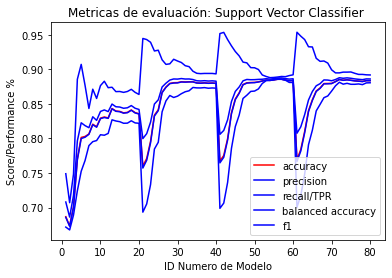

El mejor modelo ID # 56 de grupo MF tiene hiper parámetros: 
C inverso: 8.858667904100823
El grado del polinomio: 3
Accuracy óptimo: 0.8856944444444445


In [8]:
# Sintonizacion 
# MODELO OPTIMO KERNEL POLY
# BASE XMF
### MODELOS
# FUNCIÓN KERNEL POLINOMIAL
# grid-search de hiper-parámetros del modelo
poly_degree = {1,2,3,4}

# Grid-search de hiper-parámetros del modelo
C_invreg = np.logspace(-3,2,num=20)
#C_invreg = np.linspace(0.001, 5, num = 20)

# Se crean listas de las métricas de evaluación a graficar.
# crear lista de metricas de evaluacion a graficar
acc_list1 = []
prec_list1 = []
rec_list1 = []
bal_acc_list1 = []
f1_list1 = []

# hiper parámetros óptimos: scoring 'accuracy'
acc_opt1 = 0

deg_opt = 0
c_opt = 0
#g_opt = None
count_opt = None

# ID numero del modelo
count1 = 1
count_list = []

# sintonización de hiper parámetros 
# validación cruzada: iterar sobre el grid search de hiper parámetros para encontrar la configuración óptima

# iterar sobre inverso de la regularización
for deg in poly_degree:
  # iterar sobre gamma que es la distancia de los datos de entrenamiento al hiper plano
  for c in C_invreg:  
      # crear modelo SupportVectorClassifier SVC
            
            # parametros: 
            #svc  = SVC(C = c, kernel = 'rbf', gamma = g, random_state=100)
            svc  = SVC(C = c, kernel = 'poly', degree = deg, gamma = 'scale')

            # K-Fold sobre los datos de entrenamiento para ajustar el modelo
            # se utiliza K-Fold para maximizar scoring = 'accuracy' (precisión en español)
            # cv = 5 número de particiones de los datos de entrenamiento
            res_acc = cross_val_score(svc,XMF_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
            avg_acc = np.mean(res_acc)

            # se agregan las demás metricas de evaluación, pero la que se quiere maximizar es 
            # scoring = 'accuracy'
            res_prec = cross_val_score(svc,XMF_train, y_train, scoring='precision', cv=5, n_jobs=-1)
            avg_prec = round(np.mean(res_prec),4)
            res_rec = cross_val_score(svc,XMF_train, y_train, scoring='recall',  cv=5, n_jobs=-1)
            avg_rec = round(np.mean(res_rec),4)
            res_bal = cross_val_score(svc,XMF_train, y_train, scoring='balanced_accuracy',  cv=5, n_jobs=-1)
            avg_bal = round(np.mean(res_bal),4)
            res_f1 = cross_val_score(svc,XMF_train, y_train, scoring='f1',  cv=5, n_jobs=-1)
            avg_f1 = round(np.mean(res_f1),4)

            # Agregar métricas de evaluación a la listas
            acc_list1.append(avg_acc)
            prec_list1.append(avg_prec)
            rec_list1.append(avg_rec)
            bal_acc_list1.append(avg_bal)
            f1_list1.append(avg_f1)
            
            


            print('Las métricas de evaluación del modelo '+ str(count1)+' con estructura : ')
            print('Regularización inversa : '+ str(c)+ ', Gamma : scale' )
            print('')
            print('Accuracy: ' + str(avg_acc))
            print('Precision: ' + str(avg_prec))
            print('Recall: ' + str(avg_rec))
            print('Balance accuracy: ' + str(avg_bal))
            print('F1: ' + str(avg_f1))
            print(' ')

            # verificar hiper parámetros óptimos para maximizar scoring = 'accuracy'
            if avg_acc > acc_opt1:
                acc_opt1 = avg_acc
                
                c_opt = c
                deg_opt = deg
                #g_opt = g
                count_opt = count1
                
            count_list.append(count1)
            count1 +=1 

# crear gráficas superpuestas
plt.plot(count_list,acc_list1, color='r', label='accuracy')
plt.plot(count_list,prec_list1, color='b', label='precision')
plt.plot(count_list,rec_list1, color='b', label='recall/TPR')
#plt.plot(count_list,spec_list1, color='b', label='specificity/TNR')
plt.plot(count_list,bal_acc_list1, color='b', label='balanced accuracy')
plt.plot(count_list,f1_list1, color='b', label='f1')

# nombre de ejes 
plt.xlabel("ID Numero de Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación: Support Vector Classifier ")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()     

print('El mejor modelo ID # '+str(count_opt)+' de grupo MF tiene hiper parámetros: ')
print('C inverso: '+ str(c_opt))
print('El grado del polinomio: '+str(deg_opt))
#print('Gamma: '+ str(g_opt))
print('Accuracy óptimo: '+ str(acc_opt1))


In [9]:
print('El mejor modelo ID # '+str(count_opt)+' de grupo MF tiene hiper parámetros: ')
print('C inverso: '+ str(c_opt))
print('El grado del polinomio: '+str(deg_opt))
#print('Gamma: '+ str(g_opt))
print('Accuracy óptimo: '+ str(acc_opt1))


El mejor modelo ID # 56 de grupo MF tiene hiper parámetros: 
C inverso: 8.858667904100823
El grado del polinomio: 3
Accuracy óptimo: 0.8856944444444445


In [6]:
# CARGAR LOS MEJORES HIPER PARÁMETROS PARA MODELO POLY BASE XMF
df_hiper_poly_xmf = pd.read_csv('df_hiper_poly_xmf.csv')

degree_opt1 = df_hiper_poly_xmf['Valor'][0]
c_opt1 = df_hiper_poly_xmf['Valor'][1]
gamma_opt1 = df_hiper_poly_xmf['Valor'][2]
mean_acc1 = df_hiper_poly_xmf['Valor'][3]
df_hiper_poly_xmf

,Unnamed: 0,Hiperparámetros,Valor
0,0,degree,3
1,1,C,8.858667904100823
2,2,gamma,scale
3,3,mean accuracy,0.8856944444444445


In [11]:
# crear DataFrame de hiper-parámetros
hiperpar_poly_xmf = {
    'degree': deg_opt,
    'C': c_opt,
    'gamma': 'scale',
    'mean accuracy': acc_opt1
    }

# crear DataFrame de hiper parametros
df_hiper_poly_xmf = pd.DataFrame([[key, hiperpar_poly_xmf[key]] for key in hiperpar_poly_xmf.keys()], columns=['Hiperparámetros ', 'Valor'])

# GUARDAR hiper parámetros de modelo poly base XMF
df_hiper_poly_xmf.to_csv('df_hiper_poly_xmf.csv')

df_hiper_poly_xmf

,Hiperparámetros,Valor
0,degree,3
1,C,8.858668
2,gamma,scale
3,mean accuracy,0.885694


In [7]:
# MODELO OPTIMO KERNEL POLY
# BASE XMF

# crear modelo con mejores hiper parametros 
svc_opt1  = SVC(C = c_opt1  , kernel = 'poly', degree = degree_opt1, gamma = 'scale', random_state = 10086)

# entrenar/ajustar mejor modelo con base XMFI
svc_opt1.fit(XMF_train, y_train)

# crear y_predict (y^) con XMFI_test
y_predict1= svc_opt1.predict(XMF_test)

print('El mejor modelo de Kernel Polinomial: ')
print('Regularización inversa: ' +str(c_opt1 ))
print('Gamma: scale' )
print('Grado de Polinomio: '+str(degree_opt1) )
print('')

#Almacenamiento Metricas

acc_opt1 = round(accuracy_score(y_test, y_predict1),5)
prec_opt1 = round(precision_score(y_test, y_predict1),5)
rec_opt1 = round(recall_score(y_test, y_predict1),5)
bal_opt1 = round(balanced_accuracy_score(y_test, y_predict1),5)
f1_opt1 = round(f1_score(y_test, y_predict1),5)

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict1),5)}')
print(f'Precision {round(precision_score(y_test, y_predict1),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict1),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict1),5)}')
print(f'F1 {round(f1_score(y_test, y_predict1),5)}')


# crear matriz de confusion
print(pd.DataFrame(confusion_matrix(y_test, y_predict1)))


metricas_poly = {
    'accuracy': acc_opt1,
    'precision': prec_opt1,
    'recall': rec_opt1,
    'balaced accuracy': bal_opt1,
    'f1': f1_opt1
    }


score1 = list(metricas_poly.values())
metricas1 = list(metricas_poly.keys())

fig = plt.figure(figsize = (10, 5))


# plot metricas de evaluacion de mejores modelos de MF y MFI
#plt.bar(x_axis - 0.2, df_metricas['Valor Modelo 11'], 0.4, label = 'MF')
#plt.bar(x_axis , df_metricas['Valor Modelo 103'], 0.4, label = 'MFI')

# creating the bar plot
plt.bar(metricas1, score1, color ='blue',
        width = 0.4)

# personalizar gráfico
#plt.xticks(x_axis, metricas)

plt.xlabel("Metricas de Evaluación")
plt.ylabel("Score/Performance")
plt.title("Métricas de evaluación: Modelo SVM Kernel Polinomial ")

# agregar leyenda y mostrar plot
#plt.legend()
plt.show()

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: an integer is required

Las métricas de evaluación del modelo 1 con estructura : 
Regularización inversa : 0.001, Gamma :0.1

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 2 con estructura : 
Regularización inversa : 0.001, Gamma :1.1473684210526316

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 3 con estructura : 
Regularización inversa : 0.001, Gamma :2.194736842105263

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 4 con estructura : 
Regularización inversa : 0.001, Gamma :3.2421052631578946

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 5 con estructura : 
Regularización inversa : 0.001, Gamma :4.289473684210526

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836


Las métricas de evaluación del modelo 40 con estructura : 
Regularización inversa : 0.0018329807108324356, Gamma :20.0

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 41 con estructura : 
Regularización inversa : 0.003359818286283781, Gamma :0.1

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 42 con estructura : 
Regularización inversa : 0.003359818286283781, Gamma :1.1473684210526316

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 43 con estructura : 
Regularización inversa : 0.003359818286283781, Gamma :2.194736842105263

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 44 con estructura : 
Regularización inversa : 0.003359818286283781, Gamma :3.2421052631578946

Accuracy

Las métricas de evaluación del modelo 78 con estructura : 
Regularización inversa : 0.006158482110660267, Gamma :17.905263157894737

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 79 con estructura : 
Regularización inversa : 0.006158482110660267, Gamma :18.95263157894737

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 80 con estructura : 
Regularización inversa : 0.006158482110660267, Gamma :20.0

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 81 con estructura : 
Regularización inversa : 0.011288378916846888, Gamma :0.1

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 82 con estructura : 
Regularización inversa : 0.011288378916846888, Gamma :1.1473684210526316

Accuracy:

Las métricas de evaluación del modelo 116 con estructura : 
Regularización inversa : 0.02069138081114789, Gamma :15.810526315789472

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 117 con estructura : 
Regularización inversa : 0.02069138081114789, Gamma :16.857894736842105

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 118 con estructura : 
Regularización inversa : 0.02069138081114789, Gamma :17.905263157894737

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 119 con estructura : 
Regularización inversa : 0.02069138081114789, Gamma :18.95263157894737

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 120 con estructura : 
Regularización inversa : 0.02069138081114789, Gamma :

Las métricas de evaluación del modelo 154 con estructura : 
Regularización inversa : 0.06951927961775606, Gamma :13.71578947368421

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 155 con estructura : 
Regularización inversa : 0.06951927961775606, Gamma :14.76315789473684

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 156 con estructura : 
Regularización inversa : 0.06951927961775606, Gamma :15.810526315789472

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 157 con estructura : 
Regularización inversa : 0.06951927961775606, Gamma :16.857894736842105

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 158 con estructura : 
Regularización inversa : 0.06951927961775606, Gamma :1

Las métricas de evaluación del modelo 192 con estructura : 
Regularización inversa : 0.23357214690901212, Gamma :11.621052631578946

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 193 con estructura : 
Regularización inversa : 0.23357214690901212, Gamma :12.668421052631578

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 194 con estructura : 
Regularización inversa : 0.23357214690901212, Gamma :13.71578947368421

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 195 con estructura : 
Regularización inversa : 0.23357214690901212, Gamma :14.76315789473684

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 196 con estructura : 
Regularización inversa : 0.23357214690901212, Gamma :1

Las métricas de evaluación del modelo 230 con estructura : 
Regularización inversa : 0.7847599703514607, Gamma :9.526315789473683

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 231 con estructura : 
Regularización inversa : 0.7847599703514607, Gamma :10.573684210526315

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 232 con estructura : 
Regularización inversa : 0.7847599703514607, Gamma :11.621052631578946

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 233 con estructura : 
Regularización inversa : 0.7847599703514607, Gamma :12.668421052631578

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 234 con estructura : 
Regularización inversa : 0.7847599703514607, Gamma :13.71

Las métricas de evaluación del modelo 268 con estructura : 
Regularización inversa : 2.636650898730358, Gamma :7.43157894736842

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 269 con estructura : 
Regularización inversa : 2.636650898730358, Gamma :8.478947368421052

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 270 con estructura : 
Regularización inversa : 2.636650898730358, Gamma :9.526315789473683

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 271 con estructura : 
Regularización inversa : 2.636650898730358, Gamma :10.573684210526315

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 272 con estructura : 
Regularización inversa : 2.636650898730358, Gamma :11.6210526315

Las métricas de evaluación del modelo 306 con estructura : 
Regularización inversa : 8.858667904100823, Gamma :5.336842105263157

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 307 con estructura : 
Regularización inversa : 8.858667904100823, Gamma :6.384210526315789

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 308 con estructura : 
Regularización inversa : 8.858667904100823, Gamma :7.43157894736842

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 309 con estructura : 
Regularización inversa : 8.858667904100823, Gamma :8.478947368421052

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 310 con estructura : 
Regularización inversa : 8.858667904100823, Gamma :9.526315789473

Las métricas de evaluación del modelo 344 con estructura : 
Regularización inversa : 29.763514416313193, Gamma :3.2421052631578946

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 345 con estructura : 
Regularización inversa : 29.763514416313193, Gamma :4.289473684210526

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 346 con estructura : 
Regularización inversa : 29.763514416313193, Gamma :5.336842105263157

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 347 con estructura : 
Regularización inversa : 29.763514416313193, Gamma :6.384210526315789

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 348 con estructura : 
Regularización inversa : 29.763514416313193, Gamma :7.43157

Las métricas de evaluación del modelo 382 con estructura : 
Regularización inversa : 100.0, Gamma :1.1473684210526316

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 383 con estructura : 
Regularización inversa : 100.0, Gamma :2.194736842105263

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 384 con estructura : 
Regularización inversa : 100.0, Gamma :3.2421052631578946

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 385 con estructura : 
Regularización inversa : 100.0, Gamma :4.289473684210526

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
Balance accuracy: 0.8836
F1: 0.8861
 
Las métricas de evaluación del modelo 386 con estructura : 
Regularización inversa : 100.0, Gamma :5.336842105263157

Accuracy: 0.88375
Precision: 0.8806
Recall: 0.8919
B

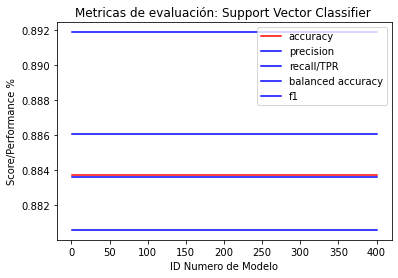

In [15]:
# Sintonizacion 
# MODELO OPTIMO KERNEL RBF
# BASE XMF

# Grid-search de hiper-parámetros del modelo
gamma = np.linspace(0.1,20,num=20)
C_invreg = np.logspace(-3,2,num=20)

#C_invreg = np.linspace(0.001, 5, num = 20)

# Se crean listas de las métricas de evaluación a graficar.
# crear lista de metricas de evaluacion a graficar
acc_list2 = []
prec_list2 = []
rec_list2 = []
bal_acc_list2 = []
f1_list2 = []

# hiper parámetros óptimos: scoring 'accuracy'
acc_opt2 = 0

c_opt = None
g_opt = None
count_opt = None

# ID numero del modelo
count1 = 1
count_list = []

# sintonización de hiper parámetros 
# validación cruzada: iterar sobre el grid search de hiper parámetros para encontrar la configuración óptima

# iterar sobre inverso de la regularización
for c in C_invreg:
  # iterar sobre gamma que es la distancia de los datos de entrenamiento al hiper plano
  for g in gamma:  
      # crear modelo SupportVectorClassifier SVC
            # parametros: 
            #svc  = SVC(C = c, kernel = 'rbf', gamma = g, random_state=100) 


            # K-Fold sobre los datos de entrenamiento para ajustar el modelo
            # se utiliza K-Fold para maximizar scoring = 'accuracy' (precisión en español)
            # cv = 5 número de particiones de los datos de entrenamiento
            res_acc = cross_val_score(svc,XMF_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
            avg_acc = np.mean(res_acc)

            # se agregan las demás metricas de evaluación, pero la que se quiere maximizar es 
            # scoring = 'accuracy'
            res_prec = cross_val_score(svc,XMF_train, y_train, scoring='precision', cv=5, n_jobs=-1)
            avg_prec = round(np.mean(res_prec),4)
            res_rec = cross_val_score(svc,XMF_train, y_train, scoring='recall',  cv=5, n_jobs=-1)
            avg_rec = round(np.mean(res_rec),4)
            res_bal = cross_val_score(svc,XMF_train, y_train, scoring='balanced_accuracy',  cv=5, n_jobs=-1)
            avg_bal = round(np.mean(res_bal),4)
            res_f1 = cross_val_score(svc,XMF_train, y_train, scoring='f1',  cv=5, n_jobs=-1)
            avg_f1 = round(np.mean(res_f1),4)

            # Agregar métricas de evaluación a la listas
            acc_list2.append(avg_acc)
            prec_list2.append(avg_prec)
            rec_list2.append(avg_rec)
            bal_acc_list2.append(avg_bal)
            f1_list2.append(avg_f1)


            print('Las métricas de evaluación del modelo '+ str(count1)+' con estructura : ')
            print('Regularización inversa : '+ str(c)+ ', Gamma :' +str(g) )
            print('')
            print('Accuracy: ' + str(avg_acc))
            print('Precision: ' + str(avg_prec))
            print('Recall: ' + str(avg_rec))
            print('Balance accuracy: ' + str(avg_bal))
            print('F1: ' + str(avg_f1))
            print(' ')

            # verificar hiper parámetros óptimos para maximizar scoring = 'accuracy'
            if avg_acc > acc_opt2:
                acc_opt2 = avg_acc
                c_opt = c
                g_opt = g
                count_opt = count1
                
            count_list.append(count1)
            count1 +=1 


# crear gráficas superpuestas
plt.plot(count_list,acc_list2, color='r', label='accuracy')
plt.plot(count_list,prec_list2, color='b', label='precision')
plt.plot(count_list,rec_list2, color='b', label='recall/TPR')
#plt.plot(count_list,spec_list1, color='b', label='specificity/TNR')
plt.plot(count_list,bal_acc_list2, color='b', label='balanced accuracy')
plt.plot(count_list,f1_list2, color='b', label='f1')

# nombre de ejes 
plt.xlabel("ID Numero de Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación: Support Vector Classifier ")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()     


In [20]:
print('El mejor modelo ID # '+str(count_opt)+' de grupo MF tiene hiper parámetros: ')
print('C inverso: '+ str(c_opt))
print('Gamma: '+ str(g_opt))
print('Accuracy óptimo: '+ str(acc_opt2))

El mejor modelo ID # 1 de grupo MF tiene hiper parámetros: 
C inverso: 0.001
Gamma: 0.1
Accuracy óptimo: 0.88375


In [19]:
# CARGAR LOS MEJORES HIPER PARÁMETROS PARA MODELO POLY BASE XMF
df_hiper_rbf_xmf = pd.read_csv('df_hiper_rbf_xmf.csv')

c_opt2 = df_hiper_rbf_xmf['Valor'][0]
gamma_opt2 = df_hiper_rbf_xmf['Valor'][1]
mean_acc2 = df_hiper_rbf_xmf['Valor'][2]
df_hiper_rbf_xmf

FileNotFoundError: [Errno 2] No such file or directory: 'df_hiper_rbf_xmf.csv'

In [18]:
# MODELO OPTIMO KERNEL RBF
# BASE XMF

# crear modelo con mejores hiper parametros 
svc_opt2  = SVC(C = c_opt2 , kernel = 'rbf', gamma = gamma_opt2 )

#SVC(C = 100, kernel = 'rbf', gamma = 0.1 )
# entrenar/ajustar mejor modelo con base XMFI
svc_opt2.fit(XMF_train, y_train)

# crear y_predict (y^) con XMFI_test
y_predict2= svc_opt2.predict(XMF_test)

print('El mejor modelo de Kernel Polinomial: ')
print('Regularización inversa: ' +str(100))
print('Gamma: '+str(0.1) )
print('')

#Almacenamiento Metricas

acc_opt2 = round(accuracy_score(y_test, y_predict2),5)
prec_opt2 = round(precision_score(y_test, y_predict2),5)
rec_opt2 = round(recall_score(y_test, y_predict2),5)
bal_opt2 = round(balanced_accuracy_score(y_test, y_predict2),5)
f1_opt2 = round(f1_score(y_test, y_predict2),5)

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict2),5)}')
print(f'Precision {round(precision_score(y_test, y_predict2),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict2),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict2),5)}')
print(f'F1 {round(f1_score(y_test, y_predict2),5)}')


# crear matriz de confusion
print(pd.DataFrame(confusion_matrix(y_test, y_predict2)))


metricas_rbf = {
    'accuracy': acc_opt2,
    'precision': prec_opt2,
    'recall': rec_opt2,
    'balaced accuracy': bal_opt2,
    'f1': f1_opt2
    }

score2 = list(metricas_rbf.values())
metricas2 = list(metricas_rbf.keys())


fig = plt.figure(figsize = (10, 5))
 

# plot metricas de evaluacion de mejores modelos de MF y MFI
#plt.bar(x_axis - 0.2, df_metricas['Valor Modelo 11'], 0.4, label = 'MF')
#plt.bar(x_axis , df_metricas['Valor Modelo 103'], 0.4, label = 'MFI')

# creating the bar plot
plt.bar(metricas2, score2, color ='blue',
        width = 0.4)

# personalizar gráfico
#plt.xticks(x_axis, metricas)

plt.xlabel("Metricas de Evaluación")
plt.ylabel("Score/Performance")
plt.title("Métricas de evaluación: Modelo SVM Kernel RBF Gaussiano ")

# agregar leyenda y mostrar plot
#plt.legend()
plt.show()



NameError: name 'c_opt2' is not defined

In [ ]:
# Sintonizacion 
# MODELO OPTIMO KERNEL POLY
# BASE XMFI

# FUNCIÓN KERNEL POLINOMIAL
# grid-search de hiper-parámetros del modelo
poly_degree = {1,2,3,4}

# Grid-search de hiper-parámetros del modelo
C_invreg = np.logspace(-3,2,num=20)
#C_invreg = np.linspace(0.001, 5, num = 20)

# Se crean listas de las métricas de evaluación a graficar.
# crear lista de metricas de evaluacion a graficar
acc_list1 = []
prec_list1 = []
rec_list1 = []
bal_acc_list1 = []
f1_list1 = []

# hiper parámetros óptimos: scoring 'accuracy'
acc_opt1 = 0

deg_opt = 0
c_opt = 0
#g_opt = None
count_opt = None

# ID numero del modelo
count1 = 1
count_list = []

# sintonización de hiper parámetros 
# validación cruzada: iterar sobre el grid search de hiper parámetros para encontrar la configuración óptima

# iterar sobre inverso de la regularización
for deg in poly_degree:
  # iterar sobre gamma que es la distancia de los datos de entrenamiento al hiper plano
  for c in C_invreg:  
      # crear modelo SupportVectorClassifier SVC
            
            # parametros: 
            #svc  = SVC(C = c, kernel = 'rbf', gamma = g, random_state=100)
            svc  = SVC(C = c, kernel = 'poly', degree = deg, gamma = 'scale')

            # K-Fold sobre los datos de entrenamiento para ajustar el modelo
            # se utiliza K-Fold para maximizar scoring = 'accuracy' (precisión en español)
            # cv = 5 número de particiones de los datos de entrenamiento
            res_acc = cross_val_score(svc,XMFI_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
            avg_acc = np.mean(res_acc)

            # se agregan las demás metricas de evaluación, pero la que se quiere maximizar es 
            # scoring = 'accuracy'
            res_prec = cross_val_score(svc,XMFI_train, y_train, scoring='precision', cv=5, n_jobs=-1)
            avg_prec = round(np.mean(res_prec),4)
            res_rec = cross_val_score(svc,XMFI_train, y_train, scoring='recall',  cv=5, n_jobs=-1)
            avg_rec = round(np.mean(res_rec),4)
            res_bal = cross_val_score(svc,XMFI_train, y_train, scoring='balanced_accuracy',  cv=5, n_jobs=-1)
            avg_bal = round(np.mean(res_bal),4)
            res_f1 = cross_val_score(svc,XMFI_train, y_train, scoring='f1',  cv=5, n_jobs=-1)
            avg_f1 = round(np.mean(res_f1),4)

            # Agregar métricas de evaluación a la listas
            acc_list1.append(avg_acc)
            prec_list1.append(avg_prec)
            rec_list1.append(avg_rec)
            bal_acc_list1.append(avg_bal)
            f1_list1.append(avg_f1)


            print('Las métricas de evaluación del modelo '+ str(count1)+' con estructura : ')
            print('Regularización inversa : '+ str(c)+ ', Gamma : scale' )
            print('')
            print('Accuracy: ' + str(avg_acc))
            print('Precision: ' + str(avg_prec))
            print('Recall: ' + str(avg_rec))
            print('Balance accuracy: ' + str(avg_bal))
            print('F1: ' + str(avg_f1))
            print(' ')

            # verificar hiper parámetros óptimos para maximizar scoring = 'accuracy'
            if avg_acc > acc_opt1:
                acc_opt1 = avg_acc
                
                c_opt = c
                deg_opt = deg
                #g_opt = g
                count_opt = count1
                
            count_list.append(count1)
            count1 +=1 

# crear gráficas superpuestas
plt.plot(count_list,acc_list1, color='r', label='accuracy')
plt.plot(count_list,prec_list1, color='b', label='precision')
plt.plot(count_list,rec_list1, color='b', label='recall/TPR')
#plt.plot(count_list,spec_list1, color='b', label='specificity/TNR')
plt.plot(count_list,bal_acc_list1, color='b', label='balanced accuracy')
plt.plot(count_list,f1_list1, color='b', label='f1')

# nombre de ejes 
plt.xlabel("ID Numero de Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación: Support Vector Classifier ")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()     


In [ ]:
print('El mejor modelo ID # '+str(count_opt)+' de grupo MF tiene hiper parámetros: ')
print('C inverso: '+ str(c_opt))
print('El grado del polinomio: '+str(deg_opt))
#print('Gamma: '+ str(g_opt))
print('Accuracy óptimo: '+ str(acc_opt1))

In [ ]:
# CARGAR LOS MEJORES HIPER PARÁMETROS PARA MODELO POLY BASE XMF
df_hiper_poly_xmfi = pd.read_csv('df_hiper_poly_xmfi.csv')

degree_opt1 = df_hiper_poly_xmfi['Valor'][0]
c_opt1 = df_hiper_poly_xmfi['Valor'][1]
gamma_opt1 = df_hiper_poly_xmfi['Valor'][2]
mean_acc1 = df_hiper_poly_xmfi['Valor'][3]
df_hiper_poly_xmfi

In [ ]:
# MODELO OPTIMO KERNEL POLY
# BASE XMFI

# crear modelo con mejores hiper parametros 
svc_opt1  = SVC (C = 2.636651, kernel = 'poly', degree =4, gamma = 'scale' )


# (C = 1.438449888287663, kernel = 'poly', degree =3, gamma = 'scale' )
# (C = 2.636651, kernel = 'poly', degree =4, gamma = 'scale' )

# entrenar/ajustar mejor modelo con base XMFI
svc_opt1.fit(XMFI_train, y_train)

# crear y_predict (y^) con XMFI_test
y_predict1= svc_opt1.predict(XMFI_test)

print('El mejor modelo de Kernel Polinomial: ')
print('Regularización inversa: ' +str(2.636651))
print('Gamma: scale' )
print('Grado de Polinomio: 4')
print('')

#Almacenamiento Metricas

acc_opt1 = round(accuracy_score(y_test, y_predict1),5)
prec_opt1 = round(precision_score(y_test, y_predict1),5)
rec_opt1 = round(recall_score(y_test, y_predict1),5)
bal_opt1 = round(balanced_accuracy_score(y_test, y_predict1),5)
f1_opt1 = round(f1_score(y_test, y_predict1),5)

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict1),5)}')
print(f'Precision {round(precision_score(y_test, y_predict1),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict1),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict1),5)}')
print(f'F1 {round(f1_score(y_test, y_predict1),5)}')


# crear matriz de confusion
print(pd.DataFrame(confusion_matrix(y_test, y_predict1)))


metricas_poly = {
    'accuracy': acc_opt1,
    'precision': prec_opt1,
    'recall': rec_opt1,
    'balaced accuracy': bal_opt1,
    'f1': f1_opt1
    }

score1 = list(metricas_poly.values())
metricas1 = list(metricas_poly.keys())


fig = plt.figure(figsize = (10, 5))
 

# plot metricas de evaluacion de mejores modelos de MF y MFI
#plt.bar(x_axis - 0.2, df_metricas['Valor Modelo 11'], 0.4, label = 'MF')
#plt.bar(x_axis , df_metricas['Valor Modelo 103'], 0.4, label = 'MFI')

# creating the bar plot
plt.bar(metricas1, score1, color ='blue',
        width = 0.4)

# personalizar gráfico
#plt.xticks(x_axis, metricas)

plt.xlabel("Metricas de Evaluación")
plt.ylabel("Score/Performance")
plt.title("Métricas de evaluación: Modelo SVM Kernel Polinomial ")

# agregar leyenda y mostrar plot
#plt.legend()
plt.show()

In [ ]:
# Sintonizacion 
# MODELO OPTIMO KERNEL RBF
# BASE XMFI

# Grid-search de hiper-parámetros del modelo
gamma = np.linspace(0.1,20,num=20)
C_invreg = np.logspace(-3,2,num=20)

#C_invreg = np.linspace(0.001, 5, num = 20)

# Se crean listas de las métricas de evaluación a graficar.
# crear lista de metricas de evaluacion a graficar
acc_list2 = []
prec_list2 = []
rec_list2 = []
bal_acc_list2 = []
f1_list2 = []

# hiper parámetros óptimos: scoring 'accuracy'
acc_opt2 = 0

c_opt = None
g_opt = None
count_opt = None

# ID numero del modelo
count1 = 1
count_list = []

# sintonización de hiper parámetros 
# validación cruzada: iterar sobre el grid search de hiper parámetros para encontrar la configuración óptima

# iterar sobre inverso de la regularización
for c in C_invreg:
  # iterar sobre gamma que es la distancia de los datos de entrenamiento al hiper plano
  for g in gamma:  
      # crear modelo SupportVectorClassifier SVC
            # parametros: 
            #svc  = SVC(C = c, kernel = 'rbf', gamma = g, random_state=100) 


            # K-Fold sobre los datos de entrenamiento para ajustar el modelo
            # se utiliza K-Fold para maximizar scoring = 'accuracy' (precisión en español)
            # cv = 5 número de particiones de los datos de entrenamiento
            res_acc = cross_val_score(svc,XMFI_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
            avg_acc = np.mean(res_acc)

            # se agregan las demás metricas de evaluación, pero la que se quiere maximizar es 
            # scoring = 'accuracy'
            res_prec = cross_val_score(svc,XMFI_train, y_train, scoring='precision', cv=5, n_jobs=-1)
            avg_prec = round(np.mean(res_prec),4)
            res_rec = cross_val_score(svc,XMFI_train, y_train, scoring='recall',  cv=5, n_jobs=-1)
            avg_rec = round(np.mean(res_rec),4)
            res_bal = cross_val_score(svc,XMFI_train, y_train, scoring='balanced_accuracy',  cv=5, n_jobs=-1)
            avg_bal = round(np.mean(res_bal),4)
            res_f1 = cross_val_score(svc,XMFI_train, y_train, scoring='f1',  cv=5, n_jobs=-1)
            avg_f1 = round(np.mean(res_f1),4)

            # Agregar métricas de evaluación a la listas
            acc_list2.append(avg_acc)
            prec_list2.append(avg_prec)
            rec_list2.append(avg_rec)
            bal_acc_list2.append(avg_bal)
            f1_list2.append(avg_f1)


            print('Las métricas de evaluación del modelo '+ str(count1)+' con estructura : ')
            print('Regularización inversa : '+ str(c)+ ', Gamma :' +str(g) )
            print('')
            print('Accuracy: ' + str(avg_acc))
            print('Precision: ' + str(avg_prec))
            print('Recall: ' + str(avg_rec))
            print('Balance accuracy: ' + str(avg_bal))
            print('F1: ' + str(avg_f1))
            print(' ')

            # verificar hiper parámetros óptimos para maximizar scoring = 'accuracy'
            if avg_acc > acc_opt2:
                acc_opt2 = avg_acc
                
                c_opt = c
                g_opt = g
                count_opt = count1
                
            count_list.append(count1)
            count1 +=1 


# crear gráficas superpuestas
plt.plot(count_list,acc_list2, color='r', label='accuracy')
plt.plot(count_list,prec_list2, color='b', label='precision')
plt.plot(count_list,rec_list2, color='b', label='recall/TPR')
#plt.plot(count_list,spec_list1, color='b', label='specificity/TNR')
plt.plot(count_list,bal_acc_list2, color='b', label='balanced accuracy')
plt.plot(count_list,f1_list2, color='b', label='f1')

# nombre de ejes 
plt.xlabel("ID Numero de Modelo")
plt.ylabel("Score/Performance %")
plt.title("Metricas de evaluación: Support Vector Classifier ")

# agregar leyenda, a partir de labels de cada grafica
plt.legend()
# mostrar grafica
plt.show()     


In [ ]:
print('El mejor modelo ID # '+str(count_opt)+' de grupo MFI tiene hiper parámetros: ')
print('C inverso: '+ str(c_opt))
print('Gamma: '+ str(g_opt))
print('Accuracy óptimo: '+ str(acc_opt2))


In [ ]:
# CARGAR LOS MEJORES HIPER PARÁMETROS PARA MODELO POLY BASE XMF
df_hiper_rbf_xmfi = pd.read_csv('df_hiper_rbf_xmfi.csv')

c_opt2 = df_hiper_rbf_xmfi['Valor'][0]
gamma_opt2 = df_hiper_rbf_xmfi['Valor'][1]
mean_acc2 = df_hiper_rbf_xmfi['Valor'][2]
df_hiper_rbf_xmfi

In [ ]:
# MODELO OPTIMO KERNEL RBF
# BASE XMFI

# crear modelo con mejores hiper parametros 
svc_opt2  = SVC(C = 0.3359818286283781 , kernel = 'rbf', gamma = 1 )


# entrenar/ajustar mejor modelo con base XMFI
svc_opt2.fit(XMFI_train, y_train)

# crear y_predict (y^) con XMFI_test
y_predict2= svc_opt2.predict(XMFI_test)

print('El mejor modelo de Kernel Polinomial: ')
print('Regularización inversa: ' +str(0.3359818286283781))
print('Gamma: '+str(1) )
print('')

#Almacenamiento Metricas

acc_opt2 = round(accuracy_score(y_test, y_predict2),5)
prec_opt2 = round(precision_score(y_test, y_predict2),5)
rec_opt2 = round(recall_score(y_test, y_predict2),5)
bal_opt2 = round(balanced_accuracy_score(y_test, y_predict2),5)
f1_opt2 = round(f1_score(y_test, y_predict2),5)

# calcular metricas de evaluacion
print(f'Accuracy {round(accuracy_score(y_test, y_predict2),5)}')
print(f'Precision {round(precision_score(y_test, y_predict2),5)}')
print(f'Sensitivity/Recall {round(recall_score(y_test, y_predict2),5)}')
print(f'Balanced Accuracy {round(balanced_accuracy_score(y_test, y_predict2),5)}')
print(f'F1 {round(f1_score(y_test, y_predict2),5)}')


# crear matriz de confusion
print(pd.DataFrame(confusion_matrix(y_test, y_predict2)))


metricas_rbf = {
    'accuracy': acc_opt2,
    'precision': prec_opt2,
    'recall': rec_opt2,
    'balaced accuracy': bal_opt2,
    'f1': f1_opt2
    }

score2 = list(metricas_rbf.values())
metricas2 = list(metricas_rbf.keys())


fig = plt.figure(figsize = (10, 5))
 

# plot metricas de evaluacion de mejores modelos de MF y MFI
#plt.bar(x_axis - 0.2, df_metricas['Valor Modelo 11'], 0.4, label = 'MF')
#plt.bar(x_axis , df_metricas['Valor Modelo 103'], 0.4, label = 'MFI')

# creating the bar plot
plt.bar(metricas2, score2, color ='blue',
        width = 0.4)

# personalizar gráfico
#plt.xticks(x_axis, metricas)

plt.xlabel("Metricas de Evaluación")
plt.ylabel("Score/Performance")
plt.title("Métricas de evaluación: Modelo SVM Kernel RBF Gaussiano ")

# agregar leyenda y mostrar plot
#plt.legend()
plt.show()

# Usando Kernel PCA

Dividimos el conjunto de datos en entrenamiento y prueba primero porque se va a realizar un análisis PCA y debemos evitar que se filtre información del conjunto de entranamiento hacia el de prueba, lo que no haría confiables los resultados obtenidos al probar el modelo con los datos de prueba.

In [8]:
# Reducción de dimensiones sin categorizar los componentes que se obtengan
X_train, X_test, y_train, y_test = train_test_split(Xdata,Ydata, test_size=0.2, random_state = 10086)

In [9]:
#Hacemos kernel PCA con X_train 

#Estandarizamos X_train
X_trainEst = estandarizacion(X_train)

#Renombramos las columnas 
X_trainEst.rename(columns={0:'Var_0',1:'Var_1', 2:'Var_2',3:'Var_3',4:'Var_4',5:'Var_5',6:'Var_6',7:'Var_7',8:'Var_8',
                   9:'Var_9',10:'Var_10',11:'Var_11',12:'Var_12',13:'Var_13',14:'Var_14',15:'Var_15'},inplace=True)

X_test.rename(columns={0:'Var_0',1:'Var_1', 2:'Var_2',3:'Var_3',4:'Var_4',5:'Var_5',6:'Var_6',7:'Var_7',8:'Var_8',
                   9:'Var_9',10:'Var_10',11:'Var_11',12:'Var_12',13:'Var_13',14:'Var_14',15:'Var_15'},inplace=True)

dfpca3=X_trainEst[ ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15']]

# Se hace reducción de dimensiones con diferentes kernel reportando la varianza explicada  y la proporción de varianza explicada
# acumulada
K = {'linear', 'poly', 'rbf', 'sigmoid', 'cosine'}
for k in K:
    kpca = KernelPCA(kernel=k,  n_components=7)
    kpca_fit = kpca.fit_transform(dfpca3)
    explained_variance = np.var( kpca_fit, axis=0)
    explained_variance_ratio = explained_variance/np.sum(explained_variance)

    print('kernel',k)
    print('Proporción Varianza explicada: ')
    print(explained_variance_ratio)
    print('Proporcion de varianza explicada acumulada:')
    print(np.cumsum(explained_variance_ratio))


kernel rbf
Proporción Varianza explicada: 
[0.35595194 0.19678611 0.15436904 0.09782033 0.07625366 0.06702489
 0.05179402]
Proporcion de varianza explicada acumulada:
[0.35595194 0.55273805 0.70710709 0.80492742 0.88118109 0.94820598
 1.        ]
kernel linear
Proporción Varianza explicada: 
[0.54237018 0.27962042 0.08159854 0.05040474 0.02795026 0.01115414
 0.00690172]
Proporcion de varianza explicada acumulada:
[0.54237018 0.8219906  0.90358914 0.95399388 0.98194414 0.99309828
 1.        ]
kernel poly
Proporción Varianza explicada: 
[0.63047077 0.13445808 0.10011626 0.05240672 0.03634357 0.02737891
 0.01882569]
Proporcion de varianza explicada acumulada:
[0.63047077 0.76492884 0.86504511 0.91745183 0.95379541 0.98117431
 1.        ]
kernel cosine
Proporción Varianza explicada: 
[0.50536989 0.23732609 0.10617729 0.08346014 0.04367273 0.01416181
 0.00983204]
Proporcion de varianza explicada acumulada:
[0.50536989 0.74269599 0.84887328 0.93233341 0.97600615 0.99016796
 1.        ]
kerne

Claramente si se extraen 4 componentes la mejor proporción de variablidad explicada la tiene el kernel lineal por lo que se hara un analisis PCA normal, seguido por el Kernel sigmoide.

In [10]:
#Para obtener el dataframe con las componentes de PCA
pca3 = PCA (n_components=4).fit(dfpca3)
columnas = ['pca_comp_%i'% i for i in range(4)]
df_pca3 = pd.DataFrame(pca3.transform(dfpca3), columns = columnas, index=dfpca3.index)
df_pca3

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3
3480,2.279539,-2.895771,-1.306145,-1.916926
2708,-4.861215,-1.128007,0.214075,0.215580
8896,1.760683,-2.960467,-0.937132,1.695270
576,-3.700488,-1.675884,0.037371,-0.598321
50,2.194536,0.459064,0.191599,-1.022980
...,...,...,...,...
8388,2.057134,-3.774656,0.464888,-1.793128
5302,1.207875,-0.407193,-0.957069,-0.575607
6756,0.013034,-0.434901,-0.411261,-0.546259
2954,3.339241,-4.082810,-0.320518,-2.560089


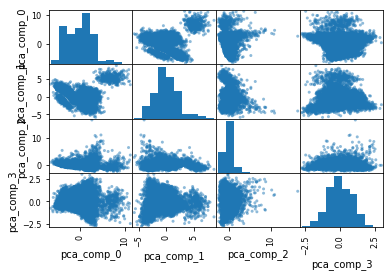

In [11]:
graph = pd.plotting.scatter_matrix(df_pca3)
plt.show()

Se observan valores atipicos en algunos de los diagramas de dispersión con el de las componentes 1 vs 3, 2 vs 3 entre otros.  

In [12]:
#Para obtener el conjunto de los 4 componentes obtenidos con el Kernel PCA usando el kernel sigmoide
kpca = KernelPCA(kernel='sigmoid',  n_components=4)
columnas2 = ['kpca_comp_0', 'kpca_comp_1', 'kpca_comp_2', 'kpca_comp_3']
Xkpca_sigmoid2 = kpca.fit_transform(dfpca3)
df_kpcasigmoid2 = pd.DataFrame(Xkpca_sigmoid2, columns = columnas2, index=dfpca3.index)
df_kpcasigmoid2

,kpca_comp_0,kpca_comp_1,kpca_comp_2,kpca_comp_3
3480,0.505176,-0.350292,-0.155718,-0.253065
2708,-0.776623,-0.447666,0.009566,0.017843
8896,0.412535,-0.407277,-0.151102,0.223808
576,-0.620512,-0.511320,0.031135,-0.143537
50,0.345614,0.149870,0.061136,-0.178627
...,...,...,...,...
8388,0.469684,-0.518174,0.094887,-0.179061
5302,0.221028,0.038873,-0.106142,-0.124496
6756,0.021652,0.013370,-0.030659,-0.122310
2954,0.743662,-0.519159,0.019964,-0.261165


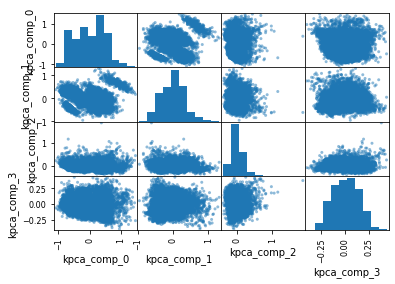

In [13]:
graph = pd.plotting.scatter_matrix(df_kpcasigmoid2)
plt.show()

Como era de esperarse se presenta lo mismo que cuando se hiceron las componentes anteriormente, así que haremos transformación de Box-Cox, que ayudaran a disminuir el sesgo de las variables y correremos de nuevo analisis kernel PCA.

In [14]:
# Se hace calculan los lambdas óptimos para cada variable que estabilizan a varianza y minimizan el sesgo
TBoxCox = PowerTransformer(method='box-cox')
TBoxCox.fit(X_train)

#Se aplica la transformación a cada variable antes de estandarizar
X_trainTBC= TBoxCox.transform(X_train)

col = {'Var_0',  'Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6', 'Var_7', 'Var_8', 'Var_9', 'Var_10', 'Var_11', 'Var_12',
      'Var_13', 'Var_14', 'Var_15',}

X_trainTBC = pd.DataFrame(X_trainTBC, columns = col, index=X_train.index)

#Se estandarizan las variables transformadas
X_trainTBCEst=estandarizacion(X_trainTBC)
X_trainTBCEst.head()

,Var_15,Var_4,Var_2,Var_11,Var_0,Var_6,Var_9,Var_12,Var_10,Var_13,Var_14,Var_1,Var_8,Var_5,Var_3,Var_7
3480,0.413582,0.489880,0.818050,-0.300517,1.642497,1.554514,0.404513,0.413582,-2.022877,0.808107,-0.861376,-1.630879,0.308838,-1.260683,-1.630879,-0.586755
2708,-2.888573,-2.673763,-2.342580,-2.711225,-0.802190,-0.824339,-2.880030,-2.888573,0.100227,-0.125246,1.028970,0.817828,2.686373,1.668869,0.817828,1.350317
8896,0.056821,0.221820,0.608305,-0.884527,1.839746,1.702626,0.059796,0.056821,1.173492,-0.517730,-1.103575,-1.821975,0.890510,-1.188424,-1.821975,-0.352203
576,-2.231057,-2.101681,-1.764936,-2.257049,-0.419894,-0.402950,-2.225228,-2.231057,-0.951124,-0.098868,0.873387,0.435122,2.242415,1.247387,0.435122,0.793328
50,1.004890,0.904453,0.894164,0.998017,0.243668,0.300587,1.004688,1.004891,-1.232929,-0.549748,-0.016525,-0.256719,-0.987975,-0.671999,-0.256719,-1.060595


In [15]:
#Hacemos kernel PCA con X_trainTBCEst 

dfpca4=X_trainTBCEst[ ['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15']]

K = {'linear', 'poly', 'rbf', 'sigmoid', 'cosine'}
for k in K:
    kpca = KernelPCA(kernel=k,  n_components=7)
    kpca_fit = kpca.fit_transform(dfpca3)
    explained_variance = np.var( kpca_fit, axis=0)
    explained_variance_ratio = explained_variance/np.sum(explained_variance)

    print('kernel',k)
    print('Proporción Varianza explicada: ')
    print(explained_variance_ratio)
    print('Proporcion de varianza explicada acumulada:')
    print(np.cumsum(explained_variance_ratio))


kernel rbf
Proporción Varianza explicada: 
[0.35595194 0.19678611 0.15436904 0.09782033 0.07625366 0.06702489
 0.05179402]
Proporcion de varianza explicada acumulada:
[0.35595194 0.55273805 0.70710709 0.80492742 0.88118109 0.94820598
 1.        ]
kernel linear
Proporción Varianza explicada: 
[0.54237018 0.27962042 0.08159854 0.05040474 0.02795026 0.01115414
 0.00690172]
Proporcion de varianza explicada acumulada:
[0.54237018 0.8219906  0.90358914 0.95399388 0.98194414 0.99309828
 1.        ]
kernel poly
Proporción Varianza explicada: 
[0.63047077 0.13445808 0.10011626 0.05240672 0.03634357 0.02737891
 0.01882569]
Proporcion de varianza explicada acumulada:
[0.63047077 0.76492884 0.86504511 0.91745183 0.95379541 0.98117431
 1.        ]
kernel cosine
Proporción Varianza explicada: 
[0.50536989 0.23732609 0.10617729 0.08346014 0.04367273 0.01416181
 0.00983204]
Proporcion de varianza explicada acumulada:
[0.50536989 0.74269599 0.84887328 0.93233341 0.97600615 0.99016796
 1.        ]
kerne

Los kernelPCA que tienen una mejor proporción de la variabilidad explicada son el lineal y el sigmoide. A continuacion se extraeran 4 compnentes con estos dos métodos

In [16]:
#Para obtener el dataframe con las componentes de PCA
pca4 = PCA (n_components=4).fit(dfpca4)
columnas = ['pca_comp_0', 'pca_comp_1', 'pca_comp_2', 'pca_com_3']
df_pca4 = pd.DataFrame(pca4.transform(dfpca4), columns = columnas, index=dfpca4.index)
df_pca4

,pca_comp_0,pca_comp_1,pca_comp_2,pca_com_3
3480,2.982405,2.420222,-1.002689,-1.785373
2708,-6.966338,3.321853,0.435353,0.516480
8896,2.504347,2.953076,-1.245971,1.472321
576,-5.134404,3.175928,0.583578,-0.399274
50,2.664835,-0.908131,0.828432,-0.896529
...,...,...,...,...
8388,2.654547,3.461575,0.785458,-0.921103
5302,1.632034,-0.117988,-0.511299,-1.156172
6756,0.414940,0.050311,0.045044,-0.792140
2954,4.170348,3.578136,0.226598,-1.391566


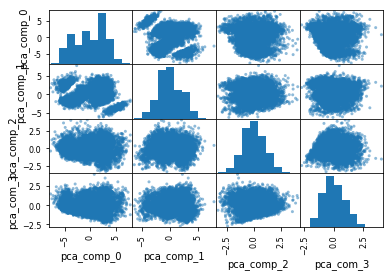

In [17]:
#Graficamos los componetes por pares en diagramas de dispersión
graph = pd.plotting.scatter_matrix(df_pca4)
plt.show()

Aunque en la gráfica anterior no se observan valores atípicos sino algunos extremos, si se observan algunos patrones como en la grafica de las componetes 1 vs 2.

In [18]:
#Para obtener el conjunto de los 4 componentes obtenidos con el Kernel PCA usando el kernel sigmoide
kpca = KernelPCA(kernel='sigmoid',  n_components=4)
columnas2 = ['kpca_comp_0', 'kpca_comp_1', 'kpca_comp_2', 'kpca_comp_3']
Xkpca_sigmoid2 = kpca.fit_transform(dfpca4)
df_kpcasigmoid2 = pd.DataFrame(Xkpca_sigmoid2, columns = columnas2, index=dfpca4.index)
df_kpcasigmoid2

,kpca_comp_0,kpca_comp_1,kpca_comp_2,kpca_comp_3
3480,0.545576,-0.360643,-0.152537,-0.247871
2708,-1.037068,-0.564236,-0.045399,-0.023794
8896,0.460156,-0.483033,-0.163212,0.224069
576,-0.822856,-0.600243,0.042817,-0.168885
50,0.444513,0.181821,0.121951,-0.161092
...,...,...,...,...
8388,0.493294,-0.559380,0.135777,-0.091092
5302,0.252258,0.053832,-0.077280,-0.176910
6756,0.040187,0.009606,0.006343,-0.126631
2954,0.785143,-0.547242,0.064753,-0.150752


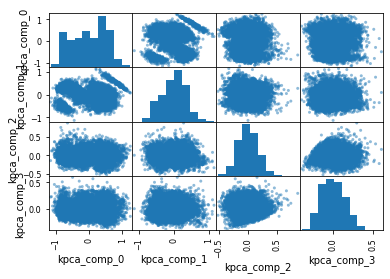

In [19]:
#Graficamos los componetes por pares en diagramas de dispersión
graph = pd.plotting.scatter_matrix(df_kpcasigmoid2)
plt.show()

La gráfica anterior en se observan mejor las nubes de puntos con valores menos extremos, en general mejor comportadas que con PCA (Lineal). Como en la gráfica anterior se observan valores extremos. Por lo anterior ajustaremos el modelo con los compontentes obtenidos con el kernel sigmoide.

In [20]:
# Se agrega la etiqueta al df_pca y se hace el análisis WoE e IV de las componentes categorizadas
df_kpcasigmoid2['Etiqueta']=y_train
#Se crea la tabla IV para las componentes
ivtable=pd.DataFrame(df_kpcasigmoid2.columns,columns=['variable'])
ivtable['IV']=None
namelist = ['kpca_comp_0', 'kpca_comp_1', 'kpca_comp_2', 'kpca_comp_3']

for i in namelist:
    ivtable.drop(ivtable[ivtable['variable'] == i].index, inplace=True)

ivtable.head()

,variable,IV
4,Etiqueta,None


In [21]:
# Se categorizan las componentes principales y se revisa si la categorización es adecuada y su poder de predicción 
# de acuerdo con lo ya explicado.   Se hace el análisis WoE e IV de las componentes categorizadas
for var in namelist:
    print('Variable:',var)
    print('')
    df_kpcasigmoid2 = get_category(df_kpcasigmoid2, var, 3, ["Bajo", "Medio", "Alto"], 'gpca', qcut = True)
    iv, data = calc_iv(df_kpcasigmoid2,'gpca_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gpca_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: kpca_comp_0

El IV de esta variable es: 0.2322461154602126
Alto     2400
Medio    2400
Bajo     2400
Name: gpca_kpca_comp_0, dtype: int64

           Variable  Value   All  Good   Bad     Share  Bad Rate  \
0  gpca_kpca_comp_0   Alto  2400   895  1505  0.333333  0.627083   
1  gpca_kpca_comp_0   Bajo  2400  1081  1319  0.333333  0.549583   
2  gpca_kpca_comp_0  Medio  2400  1571   829  0.333333  0.345417   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.252326          0.411990 -0.490278  0.078280  
1           0.304765          0.361073 -0.169541  0.009547  
2           0.442910          0.226937  0.668694  0.144420  

Variable: kpca_comp_1

El IV de esta variable es: 5.275782952601079
Alto     2400
Medio    2400
Bajo     2400
Name: gpca_kpca_comp_1, dtype: int64

           Variable  Value   All  Good   Bad     Share  Bad Rate  \
0  gpca_kpca_comp_1   Alto  2400    29  2371  0.333333  0.987917   
1  gpca_kpca_comp_1   Bajo  2400  2347    53  0.3

Los componentes 1 y 3 no tienen el WoE monotonico, se dismuniran las categorías de la componente 1 y aumentaremos las de la componente 3. Se ensayan incrementando las categorias pero el WoE sigue sin ser monotónico por lo que se deja el código final de dos categorias para ambas componentes.

In [22]:
# Se categorizan las componentes principales y se revisa si la categorización es adecuada y su poder de predicción de acuerdo con lo ya explicado.
namelist = ['kpca_comp_1','kpca_comp_3']
for var in namelist:
    print('Variable:',var)
    print('')
    df_kpcasigmoid2 = get_category(df_kpcasigmoid2, var, 2, [ "Bajo",  "Alto"], 'gpca2', qcut = True)
    iv, data = calc_iv(df_kpcasigmoid2,'gpca2_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gpca2_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: kpca_comp_1

El IV de esta variable es: 3.2488345156061533
Alto    3600
Bajo    3600
Name: gpca2_kpca_comp_1, dtype: int64

            Variable Value   All  Good   Bad  Share  Bad Rate  \
0  gpca2_kpca_comp_1  Alto  3600   372  3228    0.5  0.896667   
1  gpca2_kpca_comp_1  Bajo  3600  3175   425    0.5  0.118056   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.104877          0.883657 -2.131278  1.659796  
1           0.895123          0.116343  2.040420  1.589038  

Variable: kpca_comp_3

El IV de esta variable es: 0.002026220439729739
Alto    3600
Bajo    3600
Name: gpca2_kpca_comp_3, dtype: int64

            Variable Value   All  Good   Bad  Share  Bad Rate  \
0  gpca2_kpca_comp_3  Alto  3600  1733  1867    0.5  0.518611   
1  gpca2_kpca_comp_3  Bajo  3600  1814  1786    0.5  0.496111   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.488582          0.511087 -0.045032  0.001013  
1           0.511418          0.

In [23]:
# Se categorizan las componentes principales y se revisa si la categorización es adecuada y su poder de predicción de acuerdo con lo ya explicado.
namelist = ['kpca_comp_3']
for var in namelist:
    print('Variable:',var)
    print('')
    df_kpcasigmoid2 = get_category(df_kpcasigmoid2, var, 4, ["Bajo", "Medio", "Alto", "Muy alto"], 'gpca3', qcut = True)
    iv, data = calc_iv(df_kpcasigmoid2,'gpca3_'+var,'Etiqueta')
    ivtable.loc[ivtable['variable']== 'gpca3_'+var,'IV']=iv
    print('')
    print(data)
    print('')

Variable: kpca_comp_3

El IV de esta variable es: 0.1122312127189542
Alto        1800
Medio       1800
Bajo        1800
Muy alto    1800
Name: gpca3_kpca_comp_3, dtype: int64

            Variable     Value   All  Good   Bad  Share  Bad Rate  \
0  gpca3_kpca_comp_3      Alto  1800   697  1103   0.25  0.612778   
1  gpca3_kpca_comp_3      Bajo  1800  1031   769   0.25  0.427222   
2  gpca3_kpca_comp_3     Medio  1800   783  1017   0.25  0.565000   
3  gpca3_kpca_comp_3  Muy alto  1800  1036   764   0.25  0.424444   

   Distribution Good  Distribution Bad       WoE        IV  
0           0.196504          0.301944 -0.429557  0.045292  
1           0.290668          0.210512  0.322640  0.025862  
2           0.220750          0.278401 -0.232033  0.013377  
3           0.292078          0.209143  0.334001  0.027700  



In [24]:
#Se revisan las columnas antes de crear las dummies
df_kpcasigmoid2.columns

Index(['kpca_comp_0', 'kpca_comp_1', 'kpca_comp_2', 'kpca_comp_3', 'Etiqueta',
       'gpca_kpca_comp_0', 'gpca_kpca_comp_1', 'gpca_kpca_comp_2',
       'gpca_kpca_comp_3', 'gpca2_kpca_comp_1', 'gpca2_kpca_comp_3',
       'gpca3_kpca_comp_3'],
      dtype='object')

In [25]:
#Se generan las dummies para las componentes categorizadas
df_pcasigmoid = df_kpcasigmoid2[['gpca_kpca_comp_0','gpca2_kpca_comp_1','gpca_kpca_comp_2','gpca2_kpca_comp_3']]

# Se crean las dummies de las variable
variable = ['gpca_kpca_comp_0','gpca2_kpca_comp_1','gpca_kpca_comp_2','gpca2_kpca_comp_3']

for var in variable:
    df_pcasigmoid = convert_dummy(df_pcasigmoid, var)
      
df_pcasigmoid

C:\Users\Acer\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,gpca_kpca_comp_0_Bajo,gpca_kpca_comp_0_Medio,gpca2_kpca_comp_1_Bajo,gpca_kpca_comp_2_Bajo,gpca_kpca_comp_2_Medio,gpca2_kpca_comp_3_Bajo
3480,0,0,1,1,0,1
2708,1,0,1,0,1,1
8896,0,0,1,1,0,0
576,1,0,1,0,1,1
50,0,0,0,0,0,1
...,...,...,...,...,...,...
8388,0,0,1,0,0,1
5302,0,1,0,0,1,1
6756,0,1,1,0,1,1
2954,0,0,1,0,1,1


# Sintonización de hiperparámetros para SVM Kernel Polinomial con componentes PCA (Kernel sigmoide) categorizados


In [26]:
from sklearn.svm import SVC

reg = np.logspace(-3,2,num=20)
#g = {'scale','auto'}
deg = {1,2,3,4}
acc_mejor9 = 0
C_mejor9 = 0
gamma_mejor9 = 0

for d in deg:
    for c in reg: 
        #for G in g:
            ModeloPCASig_poly = SVC(kernel = 'poly', degree = d, C = c, gamma = 'scale')
            
            #Validación cruzada
            res_acc = cross_val_score(ModeloPCASig_poly,df_pcasigmoid, y_train, scoring='accuracy',n_jobs=-1)
            acc_mean9 = np.mean(res_acc)

            print('Modelo con kernel polinomial, C=',c, 'grados=',d, 'y gamma = scale, Accuracy: ',acc_mean9)
            if acc_mean9 > acc_mejor9:
                acc_mejor9 = acc_mean9
                C_mejor9 = c
                #gamma_mejor3 = G
                d_mejor9 = d

            

print('El mejor modelo para el connjunto de datos XMFI tiene un accuracy de ',acc_mejor9, 'kernel polinomial es con hiperparametros:')
print('C:',C_mejor9)
print('Degrees:', d_mejor9)

hiper_opt_poly = {'Accuracy':acc_mejor9, 'C':C_mejor9, 'degrees':d_mejor9}

Modelo con kernel polinomial, C= 0.001 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel polinomial, C= 0.0018329807108324356 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel polinomial, C= 0.003359818286283781 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel polinomial, C= 0.006158482110660267 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel polinomial, C= 0.011288378916846888 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel polinomial, C= 0.02069138081114789 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel polinomial, C= 0.0379269019073225 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel polinomial, C= 0.06951927961775606 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel polinomial, C= 0.12742749857031335 grados= 1 y gamma = scale, Accuracy:  0.8893055555555556
Modelo con kernel po

Modelo con kernel polinomial, C= 16.23776739188721 grados= 4 y gamma = scale, Accuracy:  0.891388888888889
Modelo con kernel polinomial, C= 29.763514416313193 grados= 4 y gamma = scale, Accuracy:  0.891388888888889
Modelo con kernel polinomial, C= 54.555947811685144 grados= 4 y gamma = scale, Accuracy:  0.891388888888889
Modelo con kernel polinomial, C= 100.0 grados= 4 y gamma = scale, Accuracy:  0.891388888888889
El mejor modelo para el connjunto de datos XMFI tiene un accuracy de  0.8936111111111111 kernel polinomial es con hiperparametros:
C: 0.001
Degrees: 2


In [27]:
df_hiperparam2 = pd.DataFrame([[key, hiper_opt_poly [key]] for key in hiper_opt_poly.keys()], columns=['Hiperparametros', 'Valor'])
df_hiperparam2.to_csv('mejorSVMpoli_HiperparamPCASig.csv')

# Sintonización de hiperparámetros para SVM Kernel gaussiano (RBF) con componentes PCA (Kernel sigmoide) categorizadas

In [28]:
from sklearn.svm import SVC

reg = np.logspace(-3,5,num=20)
g = g = {0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1, 'scale'}
acc_mejor10 = 0
C_mejor10 = 0
gamma_mejor10 = 0

for c in reg: 
    for G in g:
        ModeloPCA_rbf = SVC(kernel = 'rbf', C = c, gamma = G)

        #Validación cruzada
        res_acc = cross_val_score(ModeloPCA_rbf,df_pcasigmoid, y_train, scoring='accuracy',n_jobs=-1)
        acc_mean10 = np.mean(res_acc)

        print('Modelo con kernel rbf, C=',c, 'y gamma =',G, 'Accuracy: ',acc_mean10 )
        if acc_mean10 > acc_mejor10:
            acc_mejor10 = acc_mean10
            C_mejor10 = c
            gamma_mejor10 = G
           

            

print('El mejor modelo con un accuracy de ',acc_mejor10, 'kernel rbf es con hiperparametros:')
print('C:',C_mejor10)
print('Gamma:', gamma_mejor10)

hiper_opt_rbf = {'Accuracy':acc_mejor10, 'C':C_mejor10, 'Gamma':gamma_mejor10}

Modelo con kernel rbf, C= 0.001 y gamma = 0.25 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.3 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.2 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.35 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.4 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.45 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.5 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.55 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.65 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.75 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 1 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.85 Accuracy:  0.507361111111111
Modelo con kernel rbf, C= 0.001 y gamma = 0.6 Accuracy:  0.507361111111111
Modelo con kernel rb

Modelo con kernel rbf, C= 0.04832930238571752 y gamma = 0.7 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.04832930238571752 y gamma = 0.95 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.04832930238571752 y gamma = 0.1 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.04832930238571752 y gamma = 0.15 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.04832930238571752 y gamma = scale Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.04832930238571752 y gamma = 0.8 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.04832930238571752 y gamma = 0.9 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.12742749857031335 y gamma = 0.25 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.12742749857031335 y gamma = 0.3 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.12742749857031335 y gamma = 0.2 Accuracy:  0.8893055555555556
Modelo con kernel rbf, C= 0.12742749857031335 y gamma = 0.35 Accuracy:  0.8893055555555556
Mode

Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.45 Accuracy:  0.8920833333333335
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.5 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.55 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.65 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.75 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 1 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.85 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.6 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.7 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.95 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 6.158482110660261 y gamma = 0.1 Accuracy:  0.887361111111111
Modelo con kernel rbf, C= 6.1584821106

Modelo con kernel rbf, C= 297.6351441631313 y gamma = 0.9 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.25 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.3 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.2 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.35 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.4 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.45 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.5 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.55 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.65 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703514607 y gamma = 0.75 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 784.7599703

Modelo con kernel rbf, C= 37926.90190732246 y gamma = 0.95 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 37926.90190732246 y gamma = 0.1 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 37926.90190732246 y gamma = 0.15 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 37926.90190732246 y gamma = scale Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 37926.90190732246 y gamma = 0.8 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 37926.90190732246 y gamma = 0.9 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 100000.0 y gamma = 0.25 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 100000.0 y gamma = 0.3 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 100000.0 y gamma = 0.2 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 100000.0 y gamma = 0.35 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 100000.0 y gamma = 0.4 Accuracy:  0.891388888888889
Modelo con kernel rbf, C= 100000.0 y gamma = 0.45 Accuracy:  0.891388888888889
Mod

In [29]:
df_hiperparam2 = pd.DataFrame([[key, hiper_opt_rbf [key]] for key in hiper_opt_rbf.keys()], columns=['Hiperparametros', 'Valor'])
df_hiperparam2.to_csv('mejorSVMrbf_HiperparamPCASigCont.csv')

# Preparación conjunto de prueba para el mejor modelo basado en PCA con kernel sigmoide y SVM con kernel gaussiano

In [34]:
#Se hace la misma transformacion de Box y Cox que se hizo al set de entrenamiento pero ahora al conjunto de datos de prueba
X_testTBC= TBoxCox.transform(X_test)
X_testTBC

# Se estandariza X_test con base en el vector en las medias y varianzas de los descriptores obtenidas para estandarizar 
# el conjunto de entrenamiento

Est = StandardScaler().fit(X_trainTBC)
#X_trainEst2 = Est.transform(X_trainTBC)
Xtest = Est.transform (X_testTBC)

#Se convierte XTest de nuevo a un df
columnas= [['Var_0', 'Var_1','Var_2','Var_3','Var_4','Var_5','Var_6','Var_7','Var_8','Var_9','Var_10','Var_11','Var_12',
           'Var_13','Var_14','Var_15']]

X_TestEst= pd.DataFrame(Xtest, columns = columnas, index=X_test.index)
X_TestEst

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PowerTransformer was fitted without feature names
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Var_0,Var_1,Var_2,Var_3,Var_4,Var_5,Var_6,Var_7,Var_8,Var_9,Var_10,Var_11,Var_12,Var_13,Var_14,Var_15
7156,-1.770386,-1.749785,-1.618883,-1.467460,-0.806585,-0.829190,-1.767037,-1.770386,1.972407,-0.028870,1.060112,0.806166,1.464266,1.327781,0.806166,0.153231
6186,0.051898,0.000227,-0.022836,0.108522,-0.096573,-0.053718,0.044395,0.051898,-1.349247,0.643712,0.130604,0.098532,-0.108473,0.133485,0.098533,-0.312953
627,0.022888,-0.059157,0.029501,-0.022342,0.120117,0.173774,0.020935,0.022888,1.252073,-0.027010,0.342668,-0.120895,0.028403,0.002166,-0.120895,-0.565564
7046,0.742529,0.737129,0.728875,0.654478,0.429771,0.487207,0.754785,0.742529,1.266172,-1.435888,-0.556554,-0.465464,-0.621386,-0.643631,-0.465464,-1.618755
7556,-0.736973,-0.899156,-1.427265,0.276523,-2.171348,-2.148836,-0.738879,-0.736973,0.254149,0.172477,1.362514,2.156262,-0.297430,1.780069,2.156262,1.156247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7054,0.324756,0.449213,0.747119,-0.402588,1.624727,1.540843,0.313948,0.324755,-1.717947,1.103361,-1.071150,-1.622068,0.420870,-1.200766,-1.622068,-0.916060
4185,-0.375315,-0.407223,-0.311875,-0.414466,0.016104,0.065339,-0.379295,-0.375315,-0.340296,0.302042,0.289398,-0.016561,0.421243,0.264387,-0.016561,-0.494688
5897,0.288994,0.520553,0.615893,-0.301832,1.312133,1.290478,0.289308,0.288994,-0.552664,-0.346253,-1.590599,-1.285138,0.292567,-0.941154,-1.285138,0.296170
8601,0.814592,0.901156,0.911874,0.617573,0.779104,0.821928,0.850526,0.814592,0.797316,-2.221775,-1.156769,-0.864808,-0.540141,-0.971069,-0.864808,-2.105159


In [35]:
# Se calculan las componentes obtenidas del conjunto de datos de entranamiento pero ahora en el conjunto de prueba
XTest = kpca.transform(X_TestEst)
columnas2 = ['kpca_comp_0', 'kpca_comp_1', 'kpca_comp_2', 'kpca_comp_3']
XTestPCASigCont = pd.DataFrame(XTest, columns = columnas2, index=X_TestEst.index)
XTestPCASigCont

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KernelPCA was fitted with feature names
  warnings.warn(


,kpca_comp_0,kpca_comp_1,kpca_comp_2,kpca_comp_3
7156,-0.088253,0.000972,-0.174665,0.204538
6186,0.011500,0.121628,-0.019938,0.000302
627,-0.085313,-0.090626,-0.027007,0.062865
7046,-0.202258,-0.259410,0.106325,-0.063678
7556,-0.140898,0.230918,-0.344246,0.177782
...,...,...,...,...
7054,0.167073,-0.010198,0.232280,-0.119583
4185,-0.016109,0.041028,-0.024899,0.050653
5897,0.086514,-0.077526,0.227757,-0.193767
8601,-0.225738,-0.328368,0.217257,-0.137127


In [36]:
#Se categorizan las components 0 y 2 con le mismo criterio que se hizo en el conjunto de datos de entrenamiento.
namelist =['kpca_comp_0','kpca_comp_2']
for var in namelist:
    print('Variable:',var)
    print('')
    XTestPCASigCont = get_category(XTestPCASigCont, var, 3, ["Bajo", "Medio", "Alto"], 'gpca', qcut = True)

    #Se categorizan las components 1 y 3 con le mismo criterio que se hizo en el conjunto de datos de entrenamiento.
namelist2 = ['kpca_comp_1','kpca_comp_3']
for var in namelist2:
    print('Variable:',var)
    print('')
    XTestPCASigCont = get_category(XTestPCASigCont, var, 2, ["Bajo", "Alto"], 'gpca2', qcut = True)   

XTestPCASig = XTestPCASigCont[['gpca_kpca_comp_0', 'gpca_kpca_comp_2', 'gpca2_kpca_comp_1',
       'gpca2_kpca_comp_3']]

Variable: kpca_comp_0

Variable: kpca_comp_2

Variable: kpca_comp_1

Variable: kpca_comp_3



In [37]:
#Verificación de las columnas creadas
XTestPCASigCont.columns

Index(['kpca_comp_0', 'kpca_comp_1', 'kpca_comp_2', 'kpca_comp_3',
       'gpca_kpca_comp_0', 'gpca_kpca_comp_2', 'gpca2_kpca_comp_1',
       'gpca2_kpca_comp_3'],
      dtype='object')

In [38]:
#Se generan las dummies
XTestPCASig = pd.get_dummies(XTestPCASig, drop_first=False)

In [44]:
#Se seleccionan las variables dummies que corresponden a las del conjunto de entrenamiento
XtestPCASig = XTestPCASig[['gpca_kpca_comp_0_Bajo', 'gpca_kpca_comp_0_Medio','gpca2_kpca_comp_1_Bajo','gpca_kpca_comp_2_Bajo', 
                          'gpca_kpca_comp_2_Medio',  'gpca2_kpca_comp_3_Bajo']]
XtestPCASig.columns

Index(['gpca_kpca_comp_0_Bajo', 'gpca_kpca_comp_0_Medio',
       'gpca2_kpca_comp_1_Bajo', 'gpca_kpca_comp_2_Bajo',
       'gpca_kpca_comp_2_Medio', 'gpca2_kpca_comp_3_Bajo'],
      dtype='object')

In [47]:
# Se guarda el conjunto de pruebas
XtestPCASig.to_csv('XtestPCASig.csv')

In [48]:
# Se carga el conjunto de pruebas
XtestPCASig=pd.read_csv('XtestPCASig.csv')

In [52]:
XtestPCASig= XtestPCASig.set_index('Unnamed: 0')

In [40]:
# Se verifican las colunmas de el conjunto de entrenamiento para asegurarse que se seleccionaron correctamente.
df_pcasigmoid.columns

Index(['gpca_kpca_comp_0_Bajo', 'gpca_kpca_comp_0_Medio',
       'gpca2_kpca_comp_1_Bajo', 'gpca_kpca_comp_2_Bajo',
       'gpca_kpca_comp_2_Medio', 'gpca2_kpca_comp_3_Bajo'],
      dtype='object')

# Prueba de los modelos con el conjunto de pruebas para ambos kernels

In [53]:
#Se ajusta el mejor modelo kernel polinomial
Mejor_modelo = SVC(kernel = 'poly', C = 0.001, degree=2, gamma = 'scale')
Mejor_modelo.fit(df_pcasigmoid, y_train,)

yPCA_pred = Mejor_modelo.predict(XtestPCASig)

# Evaluación
print(f"Mejor_modelo: {accuracy_score(y_test,yPCA_pred)}")
print(f"Reporte de Clasificación:\n{sk.metrics.classification_report(y_test, yPCA_pred)}")

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejor_modelo: 0.4727777777777778
Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.50      0.47      0.49       956
         1.0       0.44      0.47      0.46       844

    accuracy                           0.47      1800
   macro avg       0.47      0.47      0.47      1800
weighted avg       0.47      0.47      0.47      1800



In [46]:
#Se ajusta el mejor modelo kernel rbf
Mejor_modelo = SVC(kernel = 'rbf', C = 0.3359818286283781,  gamma = 0.75)
Mejor_modelo.fit(df_pcasigmoid, y_train)

yPCA_pred = Mejor_modelo.predict(XtestPCASig)

# Evaluación
print(f"Mejor_modelo: {accuracy_score(y_test,yPCA_pred)}")
print(f"Reporte de Clasificación:\n{sk.metrics.classification_report(y_test, yPCA_pred)}")

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mejor_modelo: 0.4727777777777778
Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.50      0.47      0.49       956
         1.0       0.44      0.47      0.46       844

    accuracy                           0.47      1800
   macro avg       0.47      0.47      0.47      1800
weighted avg       0.47      0.47      0.47      1800

